# ANÁLISE AVANÇADA DE ABSENTISMO

**Framework Analítico Completo**: Da Descrição à Prescrição

---

## Estrutura da Análise

1. **Preparação e Limpeza de Dados**
2. **Descrição Fundamental dos Dados**
3. **Conceito de Spells (Episódios de Ausência)**
4. **Métricas Core (KPIs Essenciais)**
5. **Bradford Factor Analysis**
6. **Deteção de Padrões Suspeitos**
7. **Análise de Cohorts (por Data de Ingresso)**
8. **Clustering de Perfis de Absentismo**
9. **Network Analysis (Coincidências)**
10. **Event Detection & Anomaly Detection**
11. **Visualizações Avançadas**
12. **Síntese Executiva e Ações Recomendadas**

---

## 1. PREPARAÇÃO E LIMPEZA DE DADOS

In [1]:
# Imports
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print('✓ Bibliotecas carregadas')

✓ Bibliotecas carregadas


In [3]:
# 1.1 Carregar dados
print('Carregando dados...')
df_raw = pd.read_csv('combined_data.csv')
df_raw['Data'] = pd.to_datetime(df_raw['Data'])

print(f'   Registos totais: {len(df_raw):,}')
print(f'   Colaboradores únicos: {df_raw["login_colaborador"].nunique():,}')
print(f'   Período: {df_raw["Data"].min().date()} até {df_raw["Data"].max().date()}')

# Carregar NOVOS códigos (V2)
print('\nCarregando nova classificação (Códigos_V2)...')
df_codigos = pd.read_excel('códigos_V2.xlsx')
print(f'   Códigos carregados: {len(df_codigos)}')
print(f'\nNivel 1 categories: {df_codigos["Nivel 1"].nunique()}')
print(df_codigos['Nivel 1'].value_counts())
print(f'\nNivel 2 categories: {df_codigos["Nivel 2"].nunique()}')
print(df_codigos['Nivel 2'].value_counts())

Carregando dados...
   Registos totais: 1,325,097
   Colaboradores únicos: 3,135
   Período: 2024-01-01 até 2025-06-30

Carregando nova classificação (Códigos_V2)...
   Códigos carregados: 56

Nivel 1 categories: 5
Nivel 1
Falta Justificada      20
Ausência               15
Trabalho Pago          11
Atraso                  6
Falta Injustificada     4
Name: count, dtype: int64

Nivel 2 categories: 13
Nivel 2
Ausência Médica             8
Presença                    8
Licença Mat / Pat           7
Atraso                      6
Falta Injustificada         4
Assistência Familiar        4
Ausência Justificada        4
Ferias / Feriado / Folga    4
Inatividade                 4
Exame Escolar               3
Ausência Injustificada      2
Óbito                       1
Casamento                   1
Name: count, dtype: int64


In [5]:
# 1.2 Merge com novos códigos
print('Aplicando nova classificação aos dados...')

# Merge
df_raw = df_raw.merge(
    df_codigos,
    left_on='segmento_processado_codigo',
    right_on='Codigo Segmento',
    how='left'
)

# Verificar códigos não mapeados
codigos_sem_match = df_raw[df_raw['Nivel 1'].isna()]['segmento_processado_codigo'].unique()
if len(codigos_sem_match) > 0:
    print(f'\n⚠️  ATENÇÃO: {len(codigos_sem_match)} códigos sem correspondência:')
    print(codigos_sem_match)
    print(f'   Registos afetados: {df_raw["Nivel 1"].isna().sum():,}')
else:
    print('\n✓ Todos os códigos mapeados com sucesso')

print(f'\nTotal de registos: {len(df_raw):,}')

Aplicando nova classificação aos dados...

✓ Todos os códigos mapeados com sucesso

Total de registos: 1,325,097


### 1.3 Identificar e Remover Incompatibilidades

**Particularidade dos dados**: Num mesmo dia, um colaborador pode ter **múltiplos registos**.

**Regras de Compatibilidade** (Nivel 2):
- ✅ **Atraso** + Presença
- ✅ **Atraso** + Exame Escolar  
- ✅ **Presença** + Exame Escolar
- ❌ **Tudo o resto é INCOMPATÍVEL**

Vamos criar uma matriz de compatibilidade e identificar dias problemáticos.

In [7]:
# 1.3.1 Criar matriz de compatibilidade (Nivel 2)
print('Criando matriz de compatibilidade (Nivel 2)...')

# Lista de categorias Nivel 2
lista_nivel2 = sorted(df_codigos['Nivel 2'].unique())
print(f'\nCategorias Nivel 2: {len(lista_nivel2)}')
for cat in lista_nivel2:
    print(f'  - {cat}')

# Criar matriz (default: INCOMPATÍVEL)
matriz_compat = pd.DataFrame('Incompatível', index=lista_nivel2, columns=lista_nivel2)

# REGRA 1: Categoria consigo mesma = COMPATÍVEL
for cat in lista_nivel2:
    matriz_compat.loc[cat, cat] = 'Compatível'

# REGRA 2: Apenas 3 pares compatíveis
pares_compativeis = [
    ('Atraso', 'Presença'),
    ('Atraso', 'Exame Escolar'),
    ('Presença', 'Exame Escolar')
]

for cat1, cat2 in pares_compativeis:
    if cat1 in matriz_compat.index and cat2 in matriz_compat.columns:
        matriz_compat.loc[cat1, cat2] = 'Compatível'
        matriz_compat.loc[cat2, cat1] = 'Compatível'  # Simétrica

# Exportar matriz para validação
with pd.ExcelWriter('matriz_compatibilidade_nivel2_v2.xlsx') as writer:
    matriz_compat.to_excel(writer, sheet_name='Matriz')
    
print('\n✓ Matriz de compatibilidade criada e exportada')
print(f'\nPares COMPATÍVEIS (além da diagonal):' )
for cat1, cat2 in pares_compativeis:
    print(f'  ✓ {cat1} + {cat2}')

Criando matriz de compatibilidade (Nivel 2)...

Categorias Nivel 2: 13
  - Assistência Familiar
  - Atraso
  - Ausência Injustificada
  - Ausência Justificada
  - Ausência Médica
  - Casamento
  - Exame Escolar
  - Falta Injustificada
  - Ferias / Feriado / Folga
  - Inatividade
  - Licença Mat / Pat
  - Presença
  - Óbito

✓ Matriz de compatibilidade criada e exportada

Pares COMPATÍVEIS (além da diagonal):
  ✓ Atraso + Presença
  ✓ Atraso + Exame Escolar
  ✓ Presença + Exame Escolar


In [9]:
# 1.3.2 Identificar dias com múltiplos registos
print('Identificando dias com múltiplos registos...')

registros_por_dia = df_raw.groupby(['login_colaborador', 'Data']).size()
dias_duplicados = registros_por_dia[registros_por_dia > 1]

print(f'   Dias com múltiplos registos: {len(dias_duplicados):,}')
print(f'   ({len(dias_duplicados) / len(df_raw.groupby(["login_colaborador", "Data"])) * 100:.2f}% do total de dias-colaborador)')

Identificando dias com múltiplos registos...
   Dias com múltiplos registos: 494,472
   (64.95% do total de dias-colaborador)


In [11]:
# 1.3.3 Testar incompatibilidades (VERSÃO OTIMIZADA)
print('Testando incompatibilidades nos dias duplicados...')

# PRÉ-FILTRAR apenas dias duplicados
dias_dup_list = dias_duplicados.index.tolist()
df_dup = df_raw.set_index(['login_colaborador', 'Data']).loc[dias_dup_list].reset_index()

print(f'   Registos a testar: {len(df_dup):,}')

# PRÉ-AGRUPAR dados (UMA vez!)
df_dup_grouped = df_dup.groupby(['login_colaborador', 'Data']).apply(
    lambda g: pd.Series({
        'categorias_nivel2': list(g['Nivel 2'].dropna().unique()),
        'codigos': list(g['segmento_processado_codigo'].unique()),
        'nome': g['nome_colaborador'].iloc[0]
    })
).reset_index()

print(f'   Dias únicos a testar: {len(df_dup_grouped):,}')

# Identificar incompatibilidades
print('\nTestando pares de categorias...')
dias_incompativeis = []

for idx, row in df_dup_grouped.iterrows():
    if idx % 5000 == 0 and idx > 0:
        print(f'   Processados {idx:,}/{len(df_dup_grouped):,} dias...')
    
    login = row['login_colaborador']
    data = row['Data']
    categorias = row['categorias_nivel2']
    codigos = row['codigos']
    nome = row['nome']
    
    # Testar todos os pares
    incompativel_encontrado = False
    pares_incompativeis = []
    
    for i, cat1 in enumerate(categorias):
        for cat2 in categorias[i+1:]:
            if cat1 in matriz_compat.index and cat2 in matriz_compat.columns:
                if matriz_compat.loc[cat1, cat2] == 'Incompatível':
                    incompativel_encontrado = True
                    pares_incompativeis.append(f'{cat1} + {cat2}')
    
    if incompativel_encontrado:
        dias_incompativeis.append({
            'login_colaborador': login,
            'Data': data,
            'nome_colaborador': nome,
            'categorias': ', '.join(categorias),
            'codigos': ', '.join(codigos),
            'pares_incompativeis': ' | '.join(pares_incompativeis)
        })

df_incompativeis = pd.DataFrame(dias_incompativeis)

print(f'\n✓ Teste concluído')
print(f'\n🔴 INCOMPATIBILIDADES ENCONTRADAS: {len(df_incompativeis)}')

if len(df_incompativeis) > 0:
    print(f'\nDistribuição por par incompatível:')
    for par in df_incompativeis['pares_incompativeis'].str.split(' | ').explode().value_counts().head(10).items():
        print(f'   {par[0]}: {par[1]} casos')
    
    # Exportar para Excel
    df_incompativeis.to_excel('incompatibilidades_encontradas_v2.xlsx', index=False)
    print('\n✓ Detalhes exportados para: incompatibilidades_encontradas_v2.xlsx')

Testando incompatibilidades nos dias duplicados...
   Registos a testar: 1,058,277
   Dias únicos a testar: 494,472

Testando pares de categorias...
   Processados 5,000/494,472 dias...
   Processados 10,000/494,472 dias...
   Processados 15,000/494,472 dias...
   Processados 20,000/494,472 dias...
   Processados 25,000/494,472 dias...
   Processados 30,000/494,472 dias...
   Processados 35,000/494,472 dias...
   Processados 40,000/494,472 dias...
   Processados 45,000/494,472 dias...
   Processados 50,000/494,472 dias...
   Processados 55,000/494,472 dias...
   Processados 60,000/494,472 dias...
   Processados 65,000/494,472 dias...
   Processados 70,000/494,472 dias...
   Processados 75,000/494,472 dias...
   Processados 80,000/494,472 dias...
   Processados 85,000/494,472 dias...
   Processados 90,000/494,472 dias...
   Processados 95,000/494,472 dias...
   Processados 100,000/494,472 dias...
   Processados 105,000/494,472 dias...
   Processados 110,000/494,472 dias...
   Processado

In [13]:
# 1.3.4 Remover dias incompatíveis (VERSÃO VETORIZADA)
print('Removendo dias incompatíveis...')

n_antes = len(df_raw)

if len(df_incompativeis) > 0:
    # Criar DataFrame dos dias a remover
    dias_remover = df_incompativeis[['login_colaborador', 'Data']].copy()
    
    # Merge com indicador
    df_temp = df_raw.merge(dias_remover, on=['login_colaborador', 'Data'], how='left', indicator=True)
    
    # Manter apenas linhas NÃO marcadas
    df_limpo = df_temp[df_temp['_merge'] == 'left_only'].drop('_merge', axis=1)
else:
    df_limpo = df_raw.copy()
    print('   Nenhuma incompatibilidade encontrada')

n_depois = len(df_limpo)
print(f'\n✓ Registos removidos: {n_antes - n_depois:,}')
print(f'   ({(n_antes - n_depois) / n_antes * 100:.3f}% do total)')
print(f'\nDataset limpo: {n_depois:,} registos')

Removendo dias incompatíveis...

✓ Registos removidos: 114
   (0.009% do total)

Dataset limpo: 1,324,983 registos


In [15]:
# 1.3.5 Aplicar Hierarquias e Separar Dataframes
print('\n=== APLICANDO HIERARQUIAS DE SEPARAÇÃO ===')

# ============================================================================
# 1. Identificar combinações
# ============================================================================
print('\n1. Identificando combinações...')

dias_mult = df_limpo.groupby(['login_colaborador', 'Data']).size()
dias_mult = dias_mult[dias_mult > 1].reset_index()

print(f'   Dias com múltiplos registos: {len(dias_mult):,}')

# Método rápido
dias_mult_idx = list(zip(dias_mult['login_colaborador'], dias_mult['Data']))
df_mult_only = df_limpo[df_limpo.set_index(['login_colaborador', 'Data']).index.isin(dias_mult_idx)]

df_combos = df_mult_only.groupby(['login_colaborador', 'Data']).agg({
    'Nivel 1': lambda x: ' + '.join(sorted(x.unique())),
    'Nivel 2': lambda x: ' + '.join(sorted(x.unique()))
}).reset_index()

df_combos.columns = ['login_colaborador', 'Data', 'combo_n1', 'combo_n2']

print(f'\n   Combinações Nivel 1:')
for combo, count in df_combos['combo_n1'].value_counts().head(5).items():
    print(f'      {combo:50s}: {count:,}')

# ============================================================================
# 2. Identificar casos a ELIMINAR
# ============================================================================
print('\n2. Identificando casos a eliminar...')

# Nivel 1 - casos raros
eliminar_n1 = df_combos[
    df_combos['combo_n1'].isin([
        'Falta Injustificada + Trabalho Pago',
        'Falta Justificada + Trabalho Pago',
        'Atraso + Falta Justificada'
    ])
]

print(f'   Nivel 1 - casos raros: {len(eliminar_n1)}')

# Nivel 2 - problemas
patterns = [
    'Feriado \\+ Presença',
    'Férias \\+ Presença',
    'Folga \\+ Presença',
    'Falta Injustificada \\+ Presença',
    'Assistência Familiar \\+ Presença',
    'Atraso \\+ Ausência Médica',
    'Ausência Justificada \\+ Presença'
]

eliminar_n2 = df_combos[
    df_combos['combo_n2'].str.contains('|'.join(patterns), na=False, regex=True)
]

print(f'   Nivel 2 - problemas: {len(eliminar_n2)}')

# Total
eliminar_total = pd.concat([
    eliminar_n1[['login_colaborador', 'Data']],
    eliminar_n2[['login_colaborador', 'Data']]
]).drop_duplicates()

print(f'   🔴 TOTAL A ELIMINAR: {len(eliminar_total)} dias')

# ============================================================================
# 3. ELIMINAR
# ============================================================================
print('\n3. Eliminando...')

idx_eliminar = df_limpo.set_index(['login_colaborador', 'Data']).index.isin(
    list(zip(eliminar_total['login_colaborador'], eliminar_total['Data']))
)

df_limpo = df_limpo[~idx_eliminar].copy()

print(f'   ✓ Eliminados {idx_eliminar.sum():,} registos')

# ============================================================================
# 4. SEPARAR df_atrasos
# ============================================================================
print('\n4. Separando atrasos...')

dias_atraso = df_combos[df_combos['combo_n1'] == 'Atraso + Trabalho Pago']

print(f'   Dias "Atraso + Trabalho Pago": {len(dias_atraso):,}')

# Copiar linhas de Atraso
idx_atrasos = df_limpo.set_index(['login_colaborador', 'Data']).index.isin(
    list(zip(dias_atraso['login_colaborador'], dias_atraso['Data']))
) & (df_limpo['Nivel 1'] == 'Atraso')

df_atrasos = df_limpo[idx_atrasos].copy()

print(f'   ✓ df_atrasos: {len(df_atrasos):,} registos')

# Remover do principal
df_limpo = df_limpo[~idx_atrasos].copy()

print(f'   ✓ Removidos do principal: {len(df_limpo):,} registos restantes')

# ============================================================================
# 5. AGREGAR
# ============================================================================
print('\n5. Agregando...')

agg_rules = {
    'nome_colaborador': 'first',
    'categoria_profissional': 'first',
    'segmento_processado_codigo': lambda x: ', '.join(sorted(x.unique())),
    'Nivel 1': lambda x: ', '.join(sorted(x.unique())),
    'Nivel 2': lambda x: ', '.join(sorted(x.unique())),
}

# Campos opcionais
for col in ['operacao', 'Activo?', 'DtActivacao', 'DtDesactivacao']:
    if col in df_limpo.columns:
        agg_rules[col] = 'first'

# Agregar principal
df = df_limpo.groupby(['login_colaborador', 'Data']).agg(agg_rules).reset_index()
print(f'   ✓ df (principal): {len(df):,} dias-colaborador')

# Agregar atrasos
df_atrasos = df_atrasos.groupby(['login_colaborador', 'Data']).agg(agg_rules).reset_index()
print(f'   ✓ df_atrasos: {len(df_atrasos):,} dias-colaborador')

# ============================================================================
# RESUMO
# ============================================================================
print('\n' + '='*70)
print('✅ SEPARAÇÃO CONCLUÍDA')
print('='*70)
print(f'df (absentismo)  : {len(df):,} dias (SEM atrasos)')
print(f'df_atrasos       : {len(df_atrasos):,} dias')
print(f'Dias eliminados  : {len(eliminar_total)}')
print('='*70)



=== APLICANDO HIERARQUIAS DE SEPARAÇÃO ===

1. Identificando combinações...
   Dias com múltiplos registos: 494,415

   Combinações Nivel 1:
      Trabalho Pago                                     : 456,262
      Atraso + Trabalho Pago                            : 38,153

2. Identificando casos a eliminar...
   Nivel 1 - casos raros: 0
   Nivel 2 - problemas: 0
   🔴 TOTAL A ELIMINAR: 0 dias

3. Eliminando...
   ✓ Eliminados 0 registos

4. Separando atrasos...
   Dias "Atraso + Trabalho Pago": 38,153
   ✓ df_atrasos: 38,272 registos
   ✓ Removidos do principal: 1,286,711 registos restantes

5. Agregando...
   ✓ df (principal): 761,235 dias-colaborador
   ✓ df_atrasos: 38,153 dias-colaborador

✅ SEPARAÇÃO CONCLUÍDA
df (absentismo)  : 761,235 dias (SEM atrasos)
df_atrasos       : 38,153 dias
Dias eliminados  : 0


In [17]:
# 1.4 VALIDAÇÃO FINAL DO DATASET
print('\n' + '='*70)
print('VALIDAÇÃO FINAL - DATASET LIMPO E SEPARADO')
print('='*70)

# ============================================================================
# 1. Verificar que NÃO HÁ mais dias duplicados em df
# ============================================================================
print('\n1. Verificando dias duplicados em df (principal)...')

duplicados_df = df.groupby(['login_colaborador', 'Data']).size()
duplicados_df = duplicados_df[duplicados_df > 1]

if len(duplicados_df) == 0:
    print('   ✅ NENHUM dia duplicado - agregação OK')
else:
    print(f'   ❌ ERRO: {len(duplicados_df)} dias ainda duplicados!')
    print(duplicados_df.head(10))

# ============================================================================
# 2. Verificar que NÃO HÁ mais dias duplicados em df_atrasos
# ============================================================================
print('\n2. Verificando dias duplicados em df_atrasos...')

duplicados_atr = df_atrasos.groupby(['login_colaborador', 'Data']).size()
duplicados_atr = duplicados_atr[duplicados_atr > 1]

if len(duplicados_atr) == 0:
    print('   ✅ NENHUM dia duplicado - agregação OK')
else:
    print(f'   ❌ ERRO: {len(duplicados_atr)} dias ainda duplicados!')
    print(duplicados_atr.head(10))

# ============================================================================
# 3. Verificar que df NÃO TEM Atraso
# ============================================================================
print('\n3. Verificando que df (principal) não tem Atraso...')

tem_atraso = df[df['Nivel 1'].str.contains('Atraso', na=False)]

if len(tem_atraso) == 0:
    print('   ✅ NENHUM atraso em df (principal) - separação OK')
else:
    print(f'   ❌ ERRO: {len(tem_atraso)} registos com Atraso ainda em df!')
    print(tem_atraso[['login_colaborador', 'Data', 'Nivel 1']].head(10))

# ============================================================================
# 4. Verificar que df_atrasos SÓ TEM Atraso (ou Atraso + outro)
# ============================================================================
print('\n4. Verificando que df_atrasos só tem Atraso...')

sem_atraso = df_atrasos[~df_atrasos['Nivel 1'].str.contains('Atraso', na=False)]

if len(sem_atraso) == 0:
    print('   ✅ TODOS registos em df_atrasos contêm Atraso - separação OK')
else:
    print(f'   ❌ ERRO: {len(sem_atraso)} registos SEM Atraso em df_atrasos!')
    print(sem_atraso[['login_colaborador', 'Data', 'Nivel 1']].head(10))

# ============================================================================
# 5. Verificar sobreposição (não deve haver)
# ============================================================================
print('\n5. Verificando sobreposição entre df e df_atrasos...')

df_idx = set(zip(df['login_colaborador'], df['Data']))
atr_idx = set(zip(df_atrasos['login_colaborador'], df_atrasos['Data']))

sobreposicao = df_idx & atr_idx

if len(sobreposicao) == 0:
    print('   ✅ NENHUMA sobreposição - separação OK')
else:
    print(f'   ❌ ERRO: {len(sobreposicao)} dias aparecem em AMBOS dataframes!')
    print(f'   Primeiros 10: {list(sobreposicao)[:10]}')

# ============================================================================
# 6. Distribuição Nivel 1 em df (principal)
# ============================================================================
print('\n6. Distribuição Nivel 1 em df (principal):')

dist_n1 = df['Nivel 1'].value_counts()
print(f'\n   Total categorias: {len(dist_n1)}')
for cat, count in dist_n1.head(10).items():
    pct = count / len(df) * 100
    print(f'   {cat:50s}: {count:7,} ({pct:5.2f}%)')

# ============================================================================
# 7. Verificar casos problemáticos que deviam ter sido eliminados
# ============================================================================
print('\n7. Verificando que casos problemáticos foram eliminados...')

problemas_restantes = []

# Verificar Nivel 1
for problema in ['Falta Injustificada + Trabalho Pago', 
                 'Falta Justificada + Trabalho Pago',
                 'Atraso + Falta Justificada']:
    count = df[df['Nivel 1'] == problema].shape[0]
    if count > 0:
        problemas_restantes.append((problema, count))

if len(problemas_restantes) == 0:
    print('   ✅ Nenhum caso problemático (Nivel 1) - limpeza OK')
else:
    print(f'   ❌ ERRO: Casos problemáticos ainda existem!')
    for prob, count in problemas_restantes:
        print(f'      {prob}: {count}')

# ============================================================================
# RESUMO FINAL
# ============================================================================
print('\n' + '='*70)
print('RESUMO DA VALIDAÇÃO:')
print('='*70)
print(f'df (principal)      : {len(df):,} dias-colaborador')
print(f'                      {df["login_colaborador"].nunique():,} colaboradores')
print(f'                      Período: {df["Data"].min().date()} a {df["Data"].max().date()}')
print(f'\ndf_atrasos          : {len(df_atrasos):,} dias-colaborador')
print(f'                      {df_atrasos["login_colaborador"].nunique():,} colaboradores')
print(f'\nTotal dias únicos   : {len(df_idx) + len(atr_idx):,}')
print(f'Sobreposição        : {len(sobreposicao)}')

# Verificar passes
passes = 0
total_checks = 7

if len(duplicados_df) == 0: passes += 1
if len(duplicados_atr) == 0: passes += 1
if len(tem_atraso) == 0: passes += 1
if len(sem_atraso) == 0: passes += 1
if len(sobreposicao) == 0: passes += 1
if len(problemas_restantes) == 0: passes += 1
passes += 1  # check 6 é informativo

print(f'\n✅ Checks passed: {passes}/{total_checks}')

if passes == total_checks:
    print('\n🎉 DATASET VALIDADO E PRONTO PARA ANÁLISE!')
else:
    print('\n⚠️  ATENÇÃO: Alguns checks falharam - verificar acima')

print('='*70)


VALIDAÇÃO FINAL - DATASET LIMPO E SEPARADO

1. Verificando dias duplicados em df (principal)...
   ✅ NENHUM dia duplicado - agregação OK

2. Verificando dias duplicados em df_atrasos...
   ✅ NENHUM dia duplicado - agregação OK

3. Verificando que df (principal) não tem Atraso...
   ✅ NENHUM atraso em df (principal) - separação OK

4. Verificando que df_atrasos só tem Atraso...
   ✅ TODOS registos em df_atrasos contêm Atraso - separação OK

5. Verificando sobreposição entre df e df_atrasos...
   ❌ ERRO: 38153 dias aparecem em AMBOS dataframes!
   Primeiros 10: [('08324', Timestamp('2025-02-14 00:00:00')), ('07207', Timestamp('2024-03-06 00:00:00')), ('10017', Timestamp('2024-03-30 00:00:00')), ('2126', Timestamp('2024-09-28 00:00:00')), ('5774', Timestamp('2024-05-25 00:00:00')), ('5283', Timestamp('2024-10-07 00:00:00')), ('5762', Timestamp('2024-02-06 00:00:00')), ('10144', Timestamp('2025-06-07 00:00:00')), ('09587', Timestamp('2024-05-26 00:00:00')), ('10311', Timestamp('2024-01-03

---

## 2. DESCRIÇÃO FUNDAMENTAL DOS DADOS

In [19]:
# 2.1 Estatísticas descritivas
print('=== DESCRIÇÃO DO DATASET ===')
print(f'\n📊 DIMENSÃO')
print(f'   Total de registos (dias-colaborador): {len(df):,}')
print(f'   Colaboradores únicos: {df["login_colaborador"].nunique():,}')
print(f'   Período: {df["Data"].min().date()} até {df["Data"].max().date()}')
print(f'   Dias calendário: {(df["Data"].max() - df["Data"].min()).days + 1}')

print(f'\n📋 DISTRIBUIÇÃO POR NIVEL 1')
dist_nivel1 = df['Nivel 1'].value_counts()
for cat, count in dist_nivel1.items():
    pct = count / len(df) * 100
    print(f'   {cat:25s}: {count:7,} ({pct:5.2f}%)')

print(f'\n📋 DISTRIBUIÇÃO POR NIVEL 2')
dist_nivel2 = df['Nivel 2'].value_counts()
for cat, count in dist_nivel2.head(15).items():
    pct = count / len(df) * 100
    print(f'   {cat:30s}: {count:7,} ({pct:5.2f}%)')

if 'operacao' in df.columns:
    print(f'\n🏢 OPERAÇÕES')
    print(f'   Operações únicas: {df["operacao"].nunique()}')
    print(f'   Top 10 operações:')
    for op, count in df['operacao'].value_counts().head(10).items():
        pct = count / len(df) * 100
        print(f'      {op:40s}: {count:6,} ({pct:5.2f}%)')

print(f'\n👥 CATEGORIAS PROFISSIONAIS')
print(f'   Categorias únicas: {df["categoria_profissional"].nunique()}')
for cat, count in df['categoria_profissional'].value_counts().head(10).items():
    pct = count / len(df) * 100
    print(f'   {cat:30s}: {count:6,} ({pct:5.2f}%)')

=== DESCRIÇÃO DO DATASET ===

📊 DIMENSÃO
   Total de registos (dias-colaborador): 761,235
   Colaboradores únicos: 3,135
   Período: 2024-01-01 até 2025-06-30
   Dias calendário: 547

📋 DISTRIBUIÇÃO POR NIVEL 1
   Trabalho Pago            : 718,281 (94.36%)
   Falta Justificada        :  18,934 ( 2.49%)
   Ausência                 :  18,444 ( 2.42%)
   Falta Injustificada      :   5,576 ( 0.73%)

📋 DISTRIBUIÇÃO POR NIVEL 2
   Presença                      : 667,767 (87.72%)
   Ferias / Feriado / Folga      :  56,960 ( 7.48%)
   Ausência Médica               :  18,595 ( 2.44%)
   Licença Mat / Pat             :   6,592 ( 0.87%)
   Falta Injustificada           :   5,576 ( 0.73%)
   Inatividade                   :   2,912 ( 0.38%)
   Assistência Familiar          :   1,102 ( 0.14%)
   Óbito                         :   1,027 ( 0.13%)
   Casamento                     :     407 ( 0.05%)
   Ausência Justificada          :     296 ( 0.04%)
   Exame Escolar                 :       1 ( 0.00%)



Criando visualização de distribuição temporal...


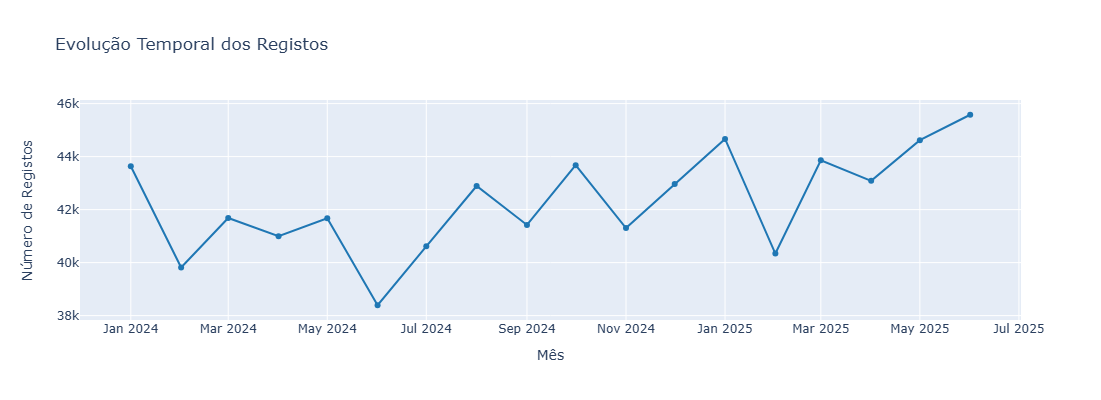

✓ Visualização criada


In [53]:
# 2.2 Visualização: Distribuição temporal
print('Criando visualização de distribuição temporal...')

# Agrupar por mês
df['Ano_Mes'] = df['Data'].dt.to_period('M').astype(str)
df_mensal = df.groupby('Ano_Mes').size().reset_index(name='Registos')

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_mensal['Ano_Mes'],
    y=df_mensal['Registos'],
    mode='lines+markers',
    name='Registos',
    line=dict(color='#1f77b4', width=2),
    marker=dict(size=6)
))

fig.update_layout(
    title='Evolução Temporal dos Registos',
    xaxis_title='Mês',
    yaxis_title='Número de Registos',
    height=400,
    hovermode='x unified'
)

fig.show()
print('✓ Visualização criada')

---

## 3. CONCEITO DE SPELLS (EPISÓDIOS DE AUSÊNCIA)

**Spell** = Episódio contínuo de ausência (um ou mais dias consecutivos).

**Importância**:
- 1 spell de 5 dias vs 5 spells de 1 dia = **impacto operacional MUITO diferente**
- Permite calcular métricas sofisticadas:
  - **Frequency Rate**: Taxa de spells por colaborador
  - **Mean Spell Duration**: Duração média de cada episódio
  - **Short-term spells**: ≤ 3 dias (possível "abuso")
  - **Long-term spells**: > 14 dias (doença grave, tratamento médico)

**Algoritmo**:
1. Ordenar registos por colaborador e data
2. Identificar quebras de continuidade (gap > 1 dia)
3. Agrupar dias consecutivos no mesmo spell
4. Calcular duração, tipo predominante, etc.

In [55]:
# 3.1 Criar spells de AUSÊNCIA (excluir Presenças e Atrasos)
print('Criando spells de ausência...')

# Filtrar apenas AUSÊNCIAS (excluir Trabalho Pago, Atraso)
df_ausencias = df[df['Nivel 1'].isin(['Falta Justificada', 'Falta Injustificada', 'Ausência'])].copy()

print(f'   Registos de ausência: {len(df_ausencias):,}')
print(f'   Colaboradores com ausências: {df_ausencias["login_colaborador"].nunique():,}')

# Ordenar por colaborador e data
df_ausencias = df_ausencias.sort_values(['login_colaborador', 'Data']).reset_index(drop=True)

# Calcular diferença de dias entre registos consecutivos
df_ausencias['dias_desde_anterior'] = df_ausencias.groupby('login_colaborador')['Data'].diff().dt.days

# Novo spell quando:
# 1. Primeiro registo do colaborador (dias_desde_anterior = NaN)
# 2. Gap > 1 dia (não consecutivo)
df_ausencias['novo_spell'] = (
    (df_ausencias['dias_desde_anterior'].isna()) |  # Primeiro registo
    (df_ausencias['dias_desde_anterior'] > 1)        # Gap de dias
)

# Atribuir ID único a cada spell
df_ausencias['spell_id'] = df_ausencias['novo_spell'].cumsum()

print(f'\n✓ Spells identificados: {df_ausencias["spell_id"].nunique():,}')

Criando spells de ausência...
   Registos de ausência: 42,954
   Colaboradores com ausências: 2,369

✓ Spells identificados: 12,318


In [57]:
# 3.2 Agregar informação por spell
print('Agregando informação por spell...')

df_spells = df_ausencias.groupby('spell_id').agg({
    'login_colaborador': 'first',
    'nome_colaborador': 'first',
    'categoria_profissional': 'first',
    'Data': ['min', 'max', 'count'],  # Início, fim, duração
    'Nivel 1': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],  # Tipo predominante
    'Nivel 2': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
}).reset_index()

# Renomear colunas
df_spells.columns = [
    'spell_id', 'login_colaborador', 'nome_colaborador', 'categoria_profissional',
    'data_inicio', 'data_fim', 'duracao_dias',
    'nivel1_predominante', 'nivel2_predominante'
]

# Adicionar operação se existir
if 'operacao' in df_ausencias.columns:
    df_spells = df_spells.merge(
        df_ausencias.groupby('spell_id')['operacao'].first().reset_index(),
        on='spell_id'
    )

# Adicionar features
df_spells['dia_semana_inicio'] = df_spells['data_inicio'].dt.day_name()
df_spells['dia_semana_fim'] = df_spells['data_fim'].dt.day_name()
df_spells['mes'] = df_spells['data_inicio'].dt.month
df_spells['ano'] = df_spells['data_inicio'].dt.year

# Categorizar spells
df_spells['categoria_spell'] = pd.cut(
    df_spells['duracao_dias'],
    bins=[0, 1, 3, 7, 14, float('inf')],
    labels=['1 dia', '2-3 dias', '4-7 dias', '8-14 dias', '>14 dias']
)

df_spells['short_term'] = df_spells['duracao_dias'] <= 3
df_spells['long_term'] = df_spells['duracao_dias'] > 14

print(f'\n✓ Dataset de spells criado: {len(df_spells):,} spells')
print(f'\nDistribuição por duração:')
print(df_spells['categoria_spell'].value_counts().sort_index())

print(f'\nEstatísticas de duração:')
print(f'   Média: {df_spells["duracao_dias"].mean():.2f} dias')
print(f'   Mediana: {df_spells["duracao_dias"].median():.0f} dias')
print(f'   P75: {df_spells["duracao_dias"].quantile(0.75):.0f} dias')
print(f'   P95: {df_spells["duracao_dias"].quantile(0.95):.0f} dias')
print(f'   Máximo: {df_spells["duracao_dias"].max()} dias')

Agregando informação por spell...

✓ Dataset de spells criado: 12,318 spells

Distribuição por duração:
categoria_spell
1 dia        4248
2-3 dias     5929
4-7 dias     1698
8-14 dias     170
>14 dias      273
Name: count, dtype: int64

Estatísticas de duração:
   Média: 3.49 dias
   Mediana: 2 dias
   P75: 3 dias
   P95: 6 dias
   Máximo: 334 dias


In [59]:
# 3.3 Análise de spells por colaborador
print('Analisando spells por colaborador...')

df_colab_spells = df_spells.groupby('login_colaborador').agg({
    'spell_id': 'count',  # Frequency rate (número de spells)
    'duracao_dias': ['sum', 'mean', 'median', 'std'],
    'short_term': 'sum',  # Número de spells curtos
    'long_term': 'sum',   # Número de spells longos
}).reset_index()

df_colab_spells.columns = [
    'login_colaborador', 'num_spells', 
    'total_dias_ausentes', 'mean_spell_duration', 'median_spell_duration', 'std_spell_duration',
    'num_short_term_spells', 'num_long_term_spells'
]

# Adicionar nome
df_colab_spells = df_colab_spells.merge(
    df[['login_colaborador', 'nome_colaborador']].drop_duplicates(),
    on='login_colaborador'
)

print(f'\n✓ Análise por colaborador criada: {len(df_colab_spells):,} colaboradores')
print(f'\nTop 10 colaboradores por número de spells:')
print(df_colab_spells.nlargest(10, 'num_spells')[[
    'nome_colaborador', 'num_spells', 'total_dias_ausentes', 'mean_spell_duration'
]].to_string(index=False))

Analisando spells por colaborador...

✓ Análise por colaborador criada: 2,369 colaboradores

Top 10 colaboradores por número de spells:
              nome_colaborador  num_spells  total_dias_ausentes  mean_spell_duration
               Cláudia Nguimbi          37                  103             2.783784
                  Neuvia Jimbo          35                   89             2.542857
      Teresa Zangui João Simão          34                  217             6.382353
               Ubirajara Sousa          33                   52             1.575758
    Maria Lusseviekueno Cabral          32                  168             5.250000
                   França Meno          30                  109             3.633333
              António Caramelo          29                  100             3.448276
Aldaide Lupassa Camosso Nerssy          28                  370            13.214286
        Antónia Bernardo Sonhi          26                   41             1.576923
              

---

## 4. MÉTRICAS CORE (KPIs ESSENCIAIS)

Baseadas em frameworks de HR Analytics (AIHR, Fitzgerald HR).

In [61]:
# 4.1 Calcular métricas fundamentais
print('=== MÉTRICAS CORE ===')

# Período de análise
data_inicio = df['Data'].min()
data_fim = df['Data'].max()
dias_calendario = (data_fim - data_inicio).days + 1
num_colaboradores = df['login_colaborador'].nunique()

# ⚠️ IMPORTANTE: Expandir listas de Nivel 1 e Nivel 2 para contagem correta
df_expanded = df.copy()

# Se Nivel 1 for lista, expandir
if isinstance(df_expanded['Nivel 1'].iloc[0], list):
    df_expanded = df_expanded.explode('Nivel 1')

# Se Nivel 2 for lista, expandir
if isinstance(df_expanded['Nivel 2'].iloc[0], list):
    df_expanded = df_expanded.explode('Nivel 2')

# Contar registos por tipo (agora vai funcionar!)
num_presencas = df_expanded[df_expanded['Nivel 1'] == 'Trabalho Pago'].shape[0]
num_atrasos = df_expanded[df_expanded['Nivel 1'] == 'Atraso'].shape[0]
num_faltas = df_expanded[df_expanded['Nivel 1'].isin(['Falta Justificada', 'Falta Injustificada'])].shape[0]
num_ausencias_medicas = df_expanded[df_expanded['Nivel 2'] == 'Ausência Médica'].shape[0]

# KPI 1: Taxa de Absentismo Global
# % Absentismo = Total de Faltas / (Presenças + Total de Faltas)
taxa_absentismo_global = (num_faltas / (num_presencas + num_faltas)) * 100

# KPI 2: Lost Time Rate (dias perdidos por FTE)
total_dias_perdidos = df_spells['duracao_dias'].sum()
lost_time_rate = total_dias_perdidos / num_colaboradores

# KPI 3: Frequency Rate (spells por colaborador)
frequency_rate = len(df_spells) / num_colaboradores

# KPI 4: Mean Spell Duration
mean_spell_duration = df_spells['duracao_dias'].mean()

# KPI 5: Taxa de Atrasos
# % Atrasos = Atrasos / (Presenças + Atrasos) - faz mais sentido
taxa_atrasos = (num_atrasos / (num_presencas + num_atrasos)) * 100 if (num_presencas + num_atrasos) > 0 else 0

# KPI 6: Taxa de Zero Ausências
colaboradores_sem_ausencias = num_colaboradores - df_spells['login_colaborador'].nunique()
taxa_zero_ausencias = (colaboradores_sem_ausencias / num_colaboradores) * 100

# Exibir resultados
print(f'\n📊 PERÍODO DE ANÁLISE')
print(f'   {data_inicio.date()} até {data_fim.date()} ({dias_calendario} dias)')
print(f'   Colaboradores únicos: {num_colaboradores:,}')
print(f'\n📈 MÉTRICAS PRINCIPAIS')
print(f'   Presenças: {num_presencas:,}')
print(f'   Atrasos: {num_atrasos:,}')
print(f'   Faltas (Just.+Injust.): {num_faltas:,}')
print(f'   Ausências Médicas: {num_ausencias_medicas:,}')
print(f'\n🎯 KPIs')
print(f'   Taxa de Absentismo: {taxa_absentismo_global:.2f}%')
print(f'   Taxa de Atrasos: {taxa_atrasos:.2f}%')
print(f'   Lost Time Rate: {lost_time_rate:.1f} dias/colaborador')
print(f'   Frequency Rate: {frequency_rate:.2f} spells/colaborador')
print(f'   Duração Média Spell: {mean_spell_duration:.1f} dias')
print(f'   Colaboradores sem ausências: {taxa_zero_ausencias:.1f}%')


=== MÉTRICAS CORE ===

📊 PERÍODO DE ANÁLISE
   2024-01-01 até 2025-06-30 (547 dias)
   Colaboradores únicos: 3,135

📈 MÉTRICAS PRINCIPAIS
   Presenças: 718,281
   Atrasos: 0
   Faltas (Just.+Injust.): 24,510
   Ausências Médicas: 18,595

🎯 KPIs
   Taxa de Absentismo: 3.30%
   Taxa de Atrasos: 0.00%
   Lost Time Rate: 13.7 dias/colaborador
   Frequency Rate: 3.93 spells/colaborador
   Duração Média Spell: 3.5 dias
   Colaboradores sem ausências: 24.4%


---

## 4B. ANÁLISE ESPECÍFICA DE ATRASOS

Análise dedicada aos atrasos (delays), separada das ausências.


In [63]:
# 4B.1 Criar dataset específico para atrasos
print('=== ANÁLISE ESPECÍFICA DE ATRASOS ===\n')

# Expandir e filtrar atrasos
df_atrasos = df.copy()

# Expandir Nivel 1 se for lista
if isinstance(df_atrasos['Nivel 1'].iloc[0], list):
    df_atrasos = df_atrasos.explode('Nivel 1')

df_atrasos = df_atrasos[df_atrasos['Nivel 1'] == 'Atraso'].copy()

print(f'Total de registos de atraso: {len(df_atrasos):,}')

if len(df_atrasos) > 0:
    print(f'Colaboradores com atrasos: {df_atrasos["login_colaborador"].nunique():,}')

    # Análise por colaborador
    atrasos_por_colab = df_atrasos.groupby('login_colaborador').agg({
        'Data': 'count',
        'nome_colaborador': 'first'
    }).rename(columns={'Data': 'num_atrasos'}).sort_values('num_atrasos', ascending=False)

    print(f'\n📊 Estatísticas:')
    print(f'   Média: {atrasos_por_colab["num_atrasos"].mean():.1f} atrasos/colaborador')
    print(f'   Mediana: {atrasos_por_colab["num_atrasos"].median():.0f}')
    print(f'   Máximo: {atrasos_por_colab["num_atrasos"].max():.0f}')

    # Top 10
    print(f'\n🔝 TOP 10 COLABORADORES COM MAIS ATRASOS:\n')
    for idx, (login, row) in enumerate(atrasos_por_colab.head(10).iterrows(), 1):
        print(f'{idx:2d}. {row["nome_colaborador"][:40]:40s}: {row["num_atrasos"]:3d} atrasos')

    # Distribuição
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=atrasos_por_colab['num_atrasos'],
        nbinsx=30,
        marker_color='orange',
        marker_line_color='white',
        marker_line_width=1
    ))
    fig.update_layout(
        title='Distribuição de Atrasos por Colaborador',
        xaxis_title='Número de Atrasos',
        yaxis_title='Colaboradores',
        height=400
    )
    fig.show()

    # Evolução temporal
    atrasos_por_data = df_atrasos.groupby('Data').size().reset_index(name='num_atrasos')

    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(
        x=atrasos_por_data['Data'],
        y=atrasos_por_data['num_atrasos'],
        mode='lines',
        line=dict(color='orange', width=2),
        fill='tozeroy',
        fillcolor='rgba(255,165,0,0.2)'
    ))
    fig2.update_layout(
        title='Evolução Temporal de Atrasos',
        xaxis_title='Data',
        yaxis_title='Número de Atrasos',
        height=400,
        hovermode='x unified'
    )
    fig2.show()

    # Exportar
    atrasos_por_colab.to_excel('analise_atrasos.xlsx')
    print('\n✓ Exportado: analise_atrasos.xlsx')
else:
    print('⚠️  Nenhum atraso encontrado no dataset')


=== ANÁLISE ESPECÍFICA DE ATRASOS ===

Total de registos de atraso: 0
⚠️  Nenhum atraso encontrado no dataset


---

## 5. BRADFORD FACTOR ANALYSIS

**Bradford Factor** = S² × D
- S = Número de spells (episódios)
- D = Total de dias ausentes

**Princípio**: Ausências curtas e frequentes são **mais disruptivas** que ausências longas ocasionais.

**Exemplo**:
- Colaborador A: 1 spell de 10 dias → B = 1² × 10 = **10**
- Colaborador B: 10 spells de 1 dia → B = 10² × 10 = **1000** (100x pior!)

**Thresholds típicos** (Call Centre Helper):
- < 45: Aceitável
- 45-100: Conversa informal  
- 100-200: Revisão formal
- 200-500: Aviso escrito
- 500-900: Ação disciplinar
- \> 900: Preocupação séria

In [65]:
# 5.1 Calcular Bradford Factor por colaborador
print('Calculando Bradford Factor...')

df_bradford = df_colab_spells.copy()
df_bradford['bradford_score'] = (df_bradford['num_spells'] ** 2) * df_bradford['total_dias_ausentes']

# Categorizar por risk level
def categorizar_bradford(score):
    if score < 45:
        return '1. Aceitável (<45)'
    elif score < 100:
        return '2. Conversa Informal (45-100)'
    elif score < 200:
        return '3. Revisão Formal (100-200)'
    elif score < 500:
        return '4. Aviso Escrito (200-500)'
    elif score < 900:
        return '5. Ação Disciplinar (500-900)'
    else:
        return '6. Preocupação Séria (>900)'

df_bradford['risk_level'] = df_bradford['bradford_score'].apply(categorizar_bradford)

print(f'\n✓ Bradford Factor calculado para {len(df_bradford):,} colaboradores')
print(f'\nDistribuição por Risk Level:')
dist_risk = df_bradford['risk_level'].value_counts().sort_index()
for level, count in dist_risk.items():
    pct = count / len(df_bradford) * 100
    print(f'   {level:40s}: {count:4,} ({pct:5.2f}%)')

print(f'\nEstatísticas do Bradford Score:')
print(f'   Média: {df_bradford["bradford_score"].mean():.2f}')
print(f'   Mediana: {df_bradford["bradford_score"].median():.2f}')
print(f'   P75: {df_bradford["bradford_score"].quantile(0.75):.2f}')
print(f'   P90: {df_bradford["bradford_score"].quantile(0.90):.2f}')
print(f'   P95: {df_bradford["bradford_score"].quantile(0.95):.2f}')
print(f'   Máximo: {df_bradford["bradford_score"].max():.2f}')

Calculando Bradford Factor...

✓ Bradford Factor calculado para 2,369 colaboradores

Distribuição por Risk Level:
   1. Aceitável (<45)                      :  790 (33.35%)
   2. Conversa Informal (45-100)           :  254 (10.72%)
   3. Revisão Formal (100-200)             :  209 ( 8.82%)
   4. Aviso Escrito (200-500)              :  336 (14.18%)
   5. Ação Disciplinar (500-900)           :  186 ( 7.85%)
   6. Preocupação Séria (>900)             :  594 (25.07%)

Estatísticas do Bradford Score:
   Média: 2302.07
   Mediana: 144.00
   P75: 900.00
   P90: 3778.40
   P95: 8984.00
   Máximo: 290080.00


In [67]:
# 5.2 Top colaboradores para atenção de RH
print('\n🔴 TOP 20 COLABORADORES PARA ATENÇÃO DE RH (Bradford Factor)')
print('='*100)

top20_bradford = df_bradford.nlargest(20, 'bradford_score')[
    ['nome_colaborador', 'num_spells', 'total_dias_ausentes', 
     'mean_spell_duration', 'bradford_score', 'risk_level']
].copy()

top20_bradford.columns = ['Nome', 'Nº Spells', 'Total Dias', 'Duração Média', 'Bradford', 'Risk Level']

print(top20_bradford.to_string(index=False))

# Exportar para Excel
top20_bradford.to_excel('bradford_factor_top20.xlsx', index=False)
print('\n✓ Top 20 exportado para: bradford_factor_top20.xlsx')


🔴 TOP 20 COLABORADORES PARA ATENÇÃO DE RH (Bradford Factor)
                                    Nome  Nº Spells  Total Dias  Duração Média  Bradford                  Risk Level
          Aldaide Lupassa Camosso Nerssy         28         370      13.214286    290080 6. Preocupação Séria (>900)
                Teresa Zangui João Simão         34         217       6.382353    250852 6. Preocupação Séria (>900)
              Maria Lusseviekueno Cabral         32         168       5.250000    172032 6. Preocupação Séria (>900)
                         Cláudia Nguimbi         37         103       2.783784    141007 6. Preocupação Séria (>900)
                     Bernarda Nascimento         21         261      12.428571    115101 6. Preocupação Séria (>900)
Delmaira Carla Pedro dos Santos de Assis         20         275      13.750000    110000 6. Preocupação Séria (>900)
                            Neuvia Jimbo         35          89       2.542857    109025 6. Preocupação Séria (>900)
   

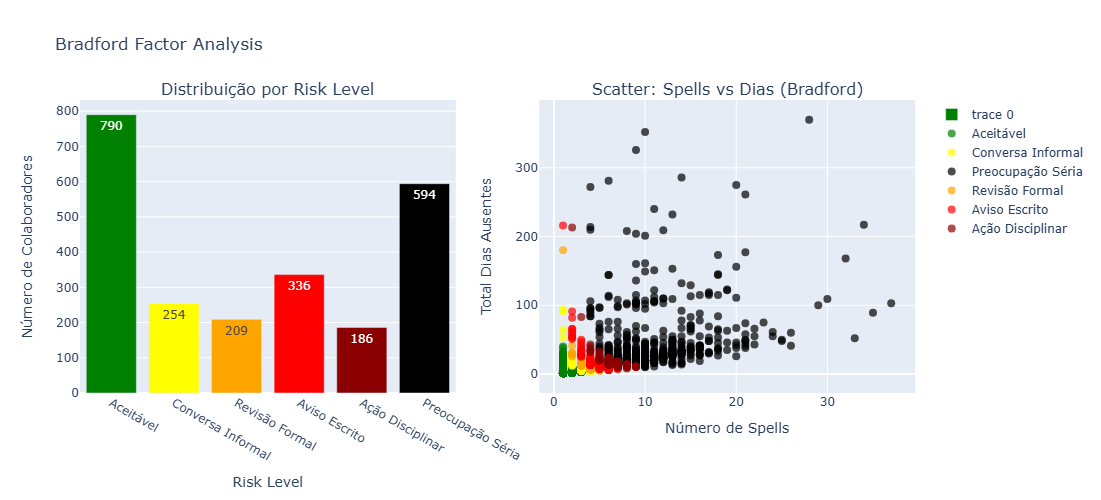

In [69]:
# 5.3 Visualização: Distribuição de Bradford Factor
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Distribuição por Risk Level', 'Scatter: Spells vs Dias (Bradford)']
)

# Gráfico 1: Barras de risk level
dist_risk_sorted = dist_risk.sort_index()
fig.add_trace(
    go.Bar(
        x=[x.split('. ')[1].split(' (')[0] for x in dist_risk_sorted.index],
        y=dist_risk_sorted.values,
        marker_color=['green', 'yellow', 'orange', 'red', 'darkred', 'black'][:len(dist_risk_sorted)],
        text=dist_risk_sorted.values,
        textposition='auto'
    ),
    row=1, col=1
)

# Gráfico 2: Scatter plot
# Colorir por risk level
color_map = {
    '1. Aceitável (<45)': 'green',
    '2. Conversa Informal (45-100)': 'yellow',
    '3. Revisão Formal (100-200)': 'orange',
    '4. Aviso Escrito (200-500)': 'red',
    '5. Ação Disciplinar (500-900)': 'darkred',
    '6. Preocupação Séria (>900)': 'black'
}

for risk_level in df_bradford['risk_level'].unique():
    df_temp = df_bradford[df_bradford['risk_level'] == risk_level]
    fig.add_trace(
        go.Scatter(
            x=df_temp['num_spells'],
            y=df_temp['total_dias_ausentes'],
            mode='markers',
            name=risk_level.split('. ')[1].split(' (')[0],
            marker=dict(
                size=8,
                color=color_map.get(risk_level, 'gray'),
                opacity=0.7
            ),
            text=df_temp['nome_colaborador'],
            hovertemplate='<b>%{text}</b><br>Spells: %{x}<br>Dias: %{y}<extra></extra>'
        ),
        row=1, col=2
    )

fig.update_xaxes(title_text='Risk Level', row=1, col=1)
fig.update_yaxes(title_text='Número de Colaboradores', row=1, col=1)
fig.update_xaxes(title_text='Número de Spells', row=1, col=2)
fig.update_yaxes(title_text='Total Dias Ausentes', row=1, col=2)

fig.update_layout(
    title='Bradford Factor Analysis',
    height=500,
    showlegend=True
)

fig.show()


Criando heatmap Bradford por Operação × Categoria...


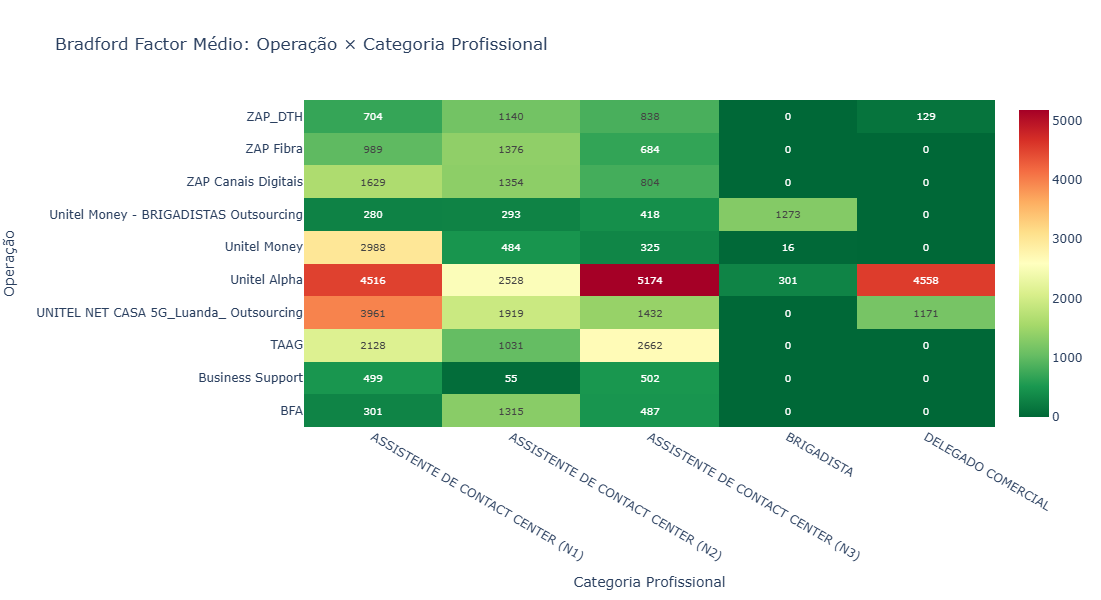

✓ Heatmap criado


In [71]:
# 5.4 Visualização EXTRA: Bradford Heatmap por Operação e Categoria
print('\nCriando heatmap Bradford por Operação × Categoria...')

if 'operacao' in df.columns:
    # Merge Bradford scores com operação
    df_bradford_op = df_bradford.merge(
        df[['login_colaborador', 'operacao']].drop_duplicates(),
        on='login_colaborador',
        how='left'
    )

    # Merge com categoria profissional
    df_bradford_op = df_bradford_op.merge(
        df[['login_colaborador', 'categoria_profissional']].drop_duplicates(),
        on='login_colaborador',
        how='left'
    )

    # Top 10 operações
    top_ops = df['operacao'].value_counts().head(10).index
    df_bradford_op_filt = df_bradford_op[df_bradford_op['operacao'].isin(top_ops)]

    # Top 5 categorias
    top_cats = df['categoria_profissional'].value_counts().head(5).index
    df_bradford_op_filt = df_bradford_op_filt[df_bradford_op_filt['categoria_profissional'].isin(top_cats)]

    # Pivot: operação × categoria
    pivot_bradford = df_bradford_op_filt.pivot_table(
        index='operacao',
        columns='categoria_profissional',
        values='bradford_score',
        aggfunc='mean'
    ).fillna(0)

    # Heatmap
    fig = go.Figure(data=go.Heatmap(
        z=pivot_bradford.values,
        x=pivot_bradford.columns,
        y=pivot_bradford.index,
        colorscale='RdYlGn_r',  # Vermelho = alto, Verde = baixo
        text=pivot_bradford.values.round(0),
        texttemplate='%{text}',
        textfont={"size": 10},
        hovertemplate='Operação: %{y}<br>Categoria: %{x}<br>Bradford Médio: %{z:.0f}<extra></extra>'
    ))

    fig.update_layout(
        title='Bradford Factor Médio: Operação × Categoria Profissional',
        xaxis_title='Categoria Profissional',
        yaxis_title='Operação',
        height=600,
        width=1000
    )

    fig.show()
    print('✓ Heatmap criado')
else:
    print('⚠️ Campo "operacao" não encontrado')


Criando funil de ação...


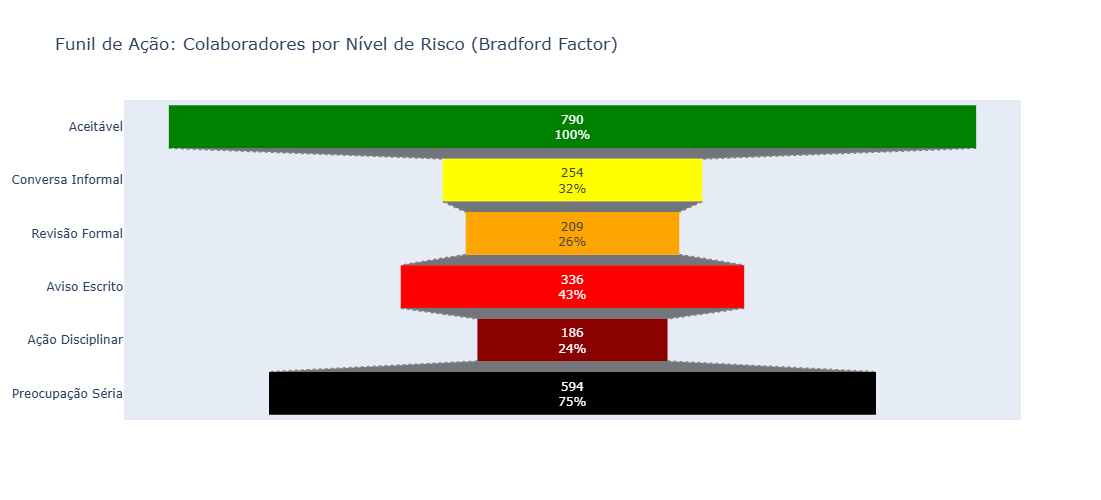


📊 FUNIL DE AÇÃO
   Aceitável                     :  790 colaboradores
   Conversa Informal             :  254 colaboradores
   Revisão Formal                :  209 colaboradores
   Aviso Escrito                 :  336 colaboradores
   Ação Disciplinar              :  186 colaboradores
   Preocupação Séria             :  594 colaboradores


In [73]:
# 5.5 Visualização EXTRA: Funil de Ação (Bradford Thresholds)
print('\nCriando funil de ação...')

# Contar colaboradores por threshold
thresholds = [
    (0, 45, 'Aceitável'),
    (45, 100, 'Conversa Informal'),
    (100, 200, 'Revisão Formal'),
    (200, 500, 'Aviso Escrito'),
    (500, 900, 'Ação Disciplinar'),
    (900, float('inf'), 'Preocupação Séria')
]

funnel_data = []
for min_val, max_val, label in thresholds:
    count = ((df_bradford['bradford_score'] >= min_val) &
             (df_bradford['bradford_score'] < max_val)).sum()
    funnel_data.append({'Nível': label, 'Colaboradores': count})

df_funnel = pd.DataFrame(funnel_data)

# Criar funil (inverted para mostrar prioridade)
fig = go.Figure()

colors = ['green', 'yellow', 'orange', 'red', 'darkred', 'black']

fig.add_trace(go.Funnel(
    y=df_funnel['Nível'],
    x=df_funnel['Colaboradores'],
    textposition='inside',
    textinfo='value+percent initial',
    marker=dict(color=colors),
    connector={"line": {"color": "gray", "dash": "dot", "width": 2}}
))

fig.update_layout(
    title='Funil de Ação: Colaboradores por Nível de Risco (Bradford Factor)',
    height=500,
    width=800
)

fig.show()

print('\n📊 FUNIL DE AÇÃO')
for _, row in df_funnel.iterrows():
    print(f'   {row["Nível"]:30s}: {row["Colaboradores"]:4,} colaboradores')


Criando timeline de spells...


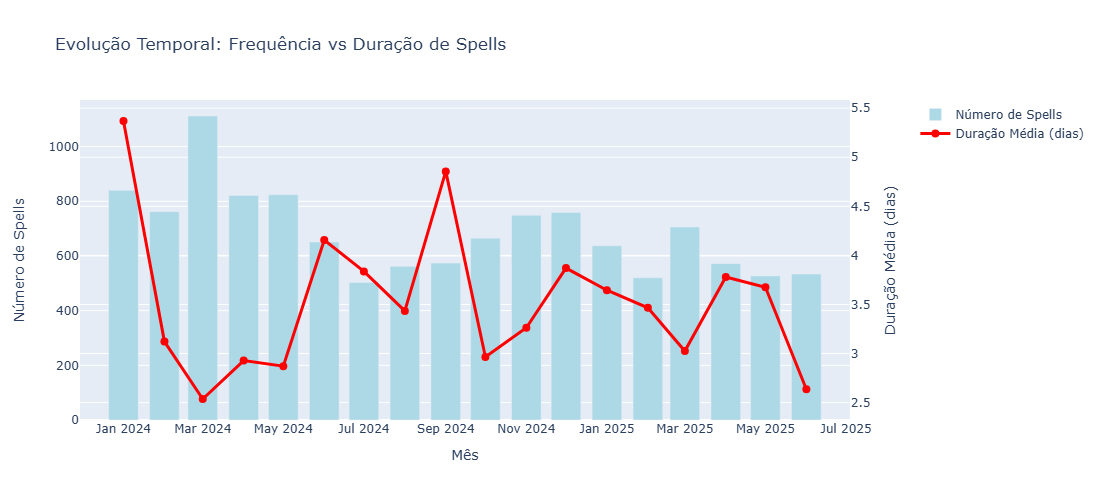

✓ Timeline criada


In [75]:
# 5.6 Visualização EXTRA: Timeline de Spells (Frequência vs Duração)
print('\nCriando timeline de spells...')

# Agrupar spells por mês
df_spells['mes_inicio'] = df_spells['data_inicio'].dt.to_period('M').astype(str)

spells_mensal = df_spells.groupby('mes_inicio').agg({
    'spell_id': 'count',
    'duracao_dias': 'mean'
}).reset_index()

spells_mensal.columns = ['Mes', 'Num_Spells', 'Duracao_Media']

# Dual-axis plot
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(
        x=spells_mensal['Mes'],
        y=spells_mensal['Num_Spells'],
        name='Número de Spells',
        marker_color='lightblue'
    ),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(
        x=spells_mensal['Mes'],
        y=spells_mensal['Duracao_Media'],
        name='Duração Média (dias)',
        mode='lines+markers',
        line=dict(color='red', width=3),
        marker=dict(size=8)
    ),
    secondary_y=True
)

fig.update_xaxes(title_text='Mês')
fig.update_yaxes(title_text='Número de Spells', secondary_y=False)
fig.update_yaxes(title_text='Duração Média (dias)', secondary_y=True)

fig.update_layout(
    title='Evolução Temporal: Frequência vs Duração de Spells',
    height=500,
    hovermode='x unified'
)

fig.show()
print('✓ Timeline criada')

---

**CONTINUA NA PRÓXIMA CÉLULA**:
- Deteção de Padrões Suspeitos
- Análise de Cohorts
- Clustering
- Network Analysis
- Event Detection
- Visualizações Avançadas

---

## 6. DETEÇÃO DE PADRÕES SUSPEITOS 🔍

**Red Flags** para possível abuso ou comportamento anómalo:
- **Weekend Pattern**: Faltas consistentes às sextas/segundas
- **Bridge Pattern**: Ausências adjacentes a feriados  
- **Temporal Consistency**: Sempre no mesmo dia/semana/mês
- **Fragmentação**: Bradford score alto com poucos dias totais

In [77]:
# 6.1 Padrão Segunda/Sexta - Spells que começam/terminam em fim de semana
print('Analisando padrões de segunda/sexta...')

# Proporção de spells que começam à segunda
spells_inicio_segunda = df_spells[df_spells['dia_semana_inicio'] == 'Monday'].shape[0]
prop_inicio_segunda = spells_inicio_segunda / len(df_spells) * 100

# Proporção de spells que terminam à sexta
spells_fim_sexta = df_spells[df_spells['dia_semana_fim'] == 'Friday'].shape[0]
prop_fim_sexta = spells_fim_sexta / len(df_spells) * 100

# Spells que combinam ambos (ponte de fim de semana)
spells_ponte_fds = df_spells[
    (df_spells['dia_semana_inicio'] == 'Monday') & 
    (df_spells['dia_semana_fim'] == 'Friday')
].shape[0]

print(f'\n📊 PADRÃO SEGUNDA/SEXTA')
print(f'   Spells que começam à segunda: {spells_inicio_segunda:,} ({prop_inicio_segunda:.2f}%)')
print(f'   Spells que terminam à sexta: {spells_fim_sexta:,} ({prop_fim_sexta:.2f}%)')
print(f'   Spells "ponte de semana" (2ª → 6ª): {spells_ponte_fds:,}')

# Análise por colaborador
df_padroes_colab = df_spells.groupby('login_colaborador').agg({
    'spell_id': 'count',
    'dia_semana_inicio': lambda x: (x == 'Monday').sum(),
    'dia_semana_fim': lambda x: (x == 'Friday').sum()
}).reset_index()

df_padroes_colab.columns = ['login_colaborador', 'total_spells', 'inicio_segunda', 'fim_sexta']

# Calcular proporções
df_padroes_colab['prop_inicio_segunda'] = df_padroes_colab['inicio_segunda'] / df_padroes_colab['total_spells']
df_padroes_colab['prop_fim_sexta'] = df_padroes_colab['fim_sexta'] / df_padroes_colab['total_spells']

# Flag: > 50% dos spells começam à segunda OU terminam à sexta
df_padroes_colab['flag_weekend_pattern'] = (
    (df_padroes_colab['prop_inicio_segunda'] > 0.5) | 
    (df_padroes_colab['prop_fim_sexta'] > 0.5)
) & (df_padroes_colab['total_spells'] >= 3)  # Mínimo 3 spells para ser significativo

# Adicionar nomes
df_padroes_colab = df_padroes_colab.merge(
    df[['login_colaborador', 'nome_colaborador']].drop_duplicates(),
    on='login_colaborador'
)

n_flagged = df_padroes_colab['flag_weekend_pattern'].sum()
print(f'\n🚩 COLABORADORES COM PADRÃO SUSPEITO: {n_flagged}')
print(f'   (>50% spells começam 2ª OU terminam 6ª, com mínimo 3 spells)')

if n_flagged > 0:
    print(f'\nTop 10:')
    top_weekend = df_padroes_colab[df_padroes_colab['flag_weekend_pattern']].nlargest(10, 'total_spells')[[
        'nome_colaborador', 'total_spells', 'inicio_segunda', 'fim_sexta', 
        'prop_inicio_segunda', 'prop_fim_sexta'
    ]].copy()
    top_weekend['prop_inicio_segunda'] = top_weekend['prop_inicio_segunda'].apply(lambda x: f'{x*100:.1f}%')
    top_weekend['prop_fim_sexta'] = top_weekend['prop_fim_sexta'].apply(lambda x: f'{x*100:.1f}%')
    print(top_weekend.to_string(index=False))

Analisando padrões de segunda/sexta...

📊 PADRÃO SEGUNDA/SEXTA
   Spells que começam à segunda: 1,847 (14.99%)
   Spells que terminam à sexta: 1,712 (13.90%)
   Spells "ponte de semana" (2ª → 6ª): 221

🚩 COLABORADORES COM PADRÃO SUSPEITO: 96
   (>50% spells começam 2ª OU terminam 6ª, com mínimo 3 spells)

Top 10:
              nome_colaborador  total_spells  inicio_segunda  fim_sexta prop_inicio_segunda prop_fim_sexta
      Marcia da Silva Laurindo            18               7         11               38.9%          61.1%
                  Joana Cacama            17               6         10               35.3%          58.8%
                  Maura Morais            15              13         11               86.7%          73.3%
              Yara Garcia Sala            14               6          9               42.9%          64.3%
Josemar Luís Ramos de Oliveira            13               9          3               69.2%          23.1%
         Adelino João Humberto            1

In [79]:
# 6.2 Padrões de Ponte - Ausências adjacentes a feriados
print('\nAnalisando padrões de ponte (adjacentes a feriados)...')

# NOTA: Precisamos de uma lista de feriados
# Para demonstração, vamos criar feriados típicos portugueses
import pandas as pd
from datetime import datetime

# Feriados fixos comuns (exemplo para um ano)
ano_min = df['Data'].min().year
ano_max = df['Data'].max().year

feriados = []
for ano in range(ano_min, ano_max + 1):
    feriados.extend([
        datetime(ano, 1, 1),   # Ano Novo
        datetime(ano, 4, 25),  # 25 de Abril
        datetime(ano, 5, 1),   # Dia do Trabalhador
        datetime(ano, 6, 10),  # Dia de Portugal
        datetime(ano, 8, 15),  # Assunção
        datetime(ano, 10, 5),  # Implantação da República
        datetime(ano, 11, 1),  # Todos os Santos
        datetime(ano, 12, 1),  # Restauração da Independência
        datetime(ano, 12, 8),  # Imaculada Conceição
        datetime(ano, 12, 25), # Natal
    ])

feriados = pd.to_datetime(feriados)

print(f'   Feriados considerados: {len(feriados)}')

# Identificar spells que começam/terminam adjacentes a feriados
def is_adjacent_to_holiday(date, holidays, tolerance=1):
    """Verifica se data está a ±tolerance dias de um feriado"""
    for holiday in holidays:
        diff = abs((date - holiday).days)
        if diff <= tolerance:
            return True
    return False

df_spells['inicio_adjacente_feriado'] = df_spells['data_inicio'].apply(
    lambda x: is_adjacent_to_holiday(x, feriados)
)

df_spells['fim_adjacente_feriado'] = df_spells['data_fim'].apply(
    lambda x: is_adjacent_to_holiday(x, feriados)
)

n_inicio_adj = df_spells['inicio_adjacente_feriado'].sum()
n_fim_adj = df_spells['fim_adjacente_feriado'].sum()

print(f'\n📊 PADRÕES DE PONTE')
print(f'   Spells que começam adjacentes a feriado: {n_inicio_adj:,} ({n_inicio_adj/len(df_spells)*100:.2f}%)')
print(f'   Spells que terminam adjacentes a feriado: {n_fim_adj:,} ({n_fim_adj/len(df_spells)*100:.2f}%)')

# Por colaborador
df_ponte_colab = df_spells.groupby('login_colaborador').agg({
    'spell_id': 'count',
    'inicio_adjacente_feriado': 'sum',
    'fim_adjacente_feriado': 'sum'
}).reset_index()

df_ponte_colab.columns = ['login_colaborador', 'total_spells', 'inicio_adj_feriado', 'fim_adj_feriado']
df_ponte_colab['prop_ponte'] = (
    (df_ponte_colab['inicio_adj_feriado'] + df_ponte_colab['fim_adj_feriado']) / 
    (df_ponte_colab['total_spells'] * 2)
)

# Flag: > 40% adjacentes a feriados
df_ponte_colab['flag_bridge_pattern'] = (
    (df_ponte_colab['prop_ponte'] > 0.4) & 
    (df_ponte_colab['total_spells'] >= 3)
)

df_ponte_colab = df_ponte_colab.merge(
    df[['login_colaborador', 'nome_colaborador']].drop_duplicates(),
    on='login_colaborador'
)

n_flagged_ponte = df_ponte_colab['flag_bridge_pattern'].sum()
print(f'\n🚩 COLABORADORES COM PADRÃO DE PONTE SUSPEITO: {n_flagged_ponte}')

if n_flagged_ponte > 0:
    print(f'\nTop 10:')
    top_ponte = df_ponte_colab[df_ponte_colab['flag_bridge_pattern']].nlargest(10, 'total_spells')[[
        'nome_colaborador', 'total_spells', 'inicio_adj_feriado', 'fim_adj_feriado'
    ]]
    print(top_ponte.to_string(index=False))


Analisando padrões de ponte (adjacentes a feriados)...
   Feriados considerados: 20

📊 PADRÕES DE PONTE
   Spells que começam adjacentes a feriado: 969 (7.87%)
   Spells que terminam adjacentes a feriado: 974 (7.91%)

🚩 COLABORADORES COM PADRÃO DE PONTE SUSPEITO: 12

Top 10:
                       nome_colaborador  total_spells  inicio_adj_feriado  fim_adj_feriado
              Marinela Isseque Quitamba             6                   2                3
            Paulo Jacinto Abreu Gabriel             6                   3                3
                     Júlio Combra Pedro             5                   2                3
 Joaquina Guilhermina Patrício Candongo             5                   3                2
                 António Diego Henrique             4                   2                2
                     David Mbele Miguel             4                   1                3
                       António Quiteque             3                   1             

In [81]:
# 6.3 Outlier Detection - Colaboradores estatisticamente fora do padrão
print('\nDeteção de outliers estatísticos...')

from scipy import stats

# Z-score para várias métricas
df_outliers = df_bradford.copy()

# Calcular Z-scores
df_outliers['z_num_spells'] = stats.zscore(df_outliers['num_spells'])
df_outliers['z_total_dias'] = stats.zscore(df_outliers['total_dias_ausentes'])
df_outliers['z_bradford'] = stats.zscore(df_outliers['bradford_score'])

# Outlier se Z-score > 3 em qualquer métrica
df_outliers['is_outlier'] = (
    (abs(df_outliers['z_num_spells']) > 3) |
    (abs(df_outliers['z_total_dias']) > 3) |
    (abs(df_outliers['z_bradford']) > 3)
)

n_outliers = df_outliers['is_outlier'].sum()
print(f'\n🎯 OUTLIERS DETETADOS: {n_outliers}')
print(f'   ({n_outliers / len(df_outliers) * 100:.2f}% dos colaboradores)')

if n_outliers > 0:
    print(f'\nOutliers (Z-score > 3 em alguma métrica):')
    outliers = df_outliers[df_outliers['is_outlier']][
        ['nome_colaborador', 'num_spells', 'total_dias_ausentes', 'bradford_score',
         'z_num_spells', 'z_total_dias', 'z_bradford']
    ].nlargest(15, 'z_bradford')
    
    for col in ['z_num_spells', 'z_total_dias', 'z_bradford']:
        outliers[col] = outliers[col].apply(lambda x: f'{x:.2f}')
    
    print(outliers.to_string(index=False))


Deteção de outliers estatísticos...

🎯 OUTLIERS DETETADOS: 80
   (3.38% dos colaboradores)

Outliers (Z-score > 3 em alguma métrica):
                        nome_colaborador  num_spells  total_dias_ausentes  bradford_score z_num_spells z_total_dias z_bradford
          Aldaide Lupassa Camosso Nerssy          28                  370          290080         5.11        11.39      24.89
                Teresa Zangui João Simão          34                  217          250852         6.46         6.44      21.50
              Maria Lusseviekueno Cabral          32                  168          172032         6.01         4.85      14.68
                         Cláudia Nguimbi          37                  103          141007         7.13         2.75      12.00
                     Bernarda Nascimento          21                  261          115101         3.54         7.86       9.76
Delmaira Carla Pedro dos Santos de Assis          20                  275          110000         3.32 

---

## 7. ANÁLISE DE COHORTS (por Data de Ingresso)

**Objetivo**: Investigar se colaboradores mais novos têm taxas de absentismo diferentes.

**Hipóteses a testar**:
- Novos colaboradores podem ter mais ausências (adaptação, problemas iniciais)
- Ou menos ausências (honeymoon period, medo de consequências)

=== ANÁLISE POR COHORT (SENIORIDADE) ===

✓ Campo DtActivacao encontrado
Colaboradores com DtActivacao válida: 3,135

📊 Absentismo por Cohort:
          num_colaboradores  total_ausencias  media_ausencias
cohort                                                       
<1 ano                  589             5894        10.006791
1-2 anos                601             8658        14.405990
2-3 anos                273             5670        20.769231
3-5 anos                232             4594        19.801724
>5 anos                 674            18138        26.910979


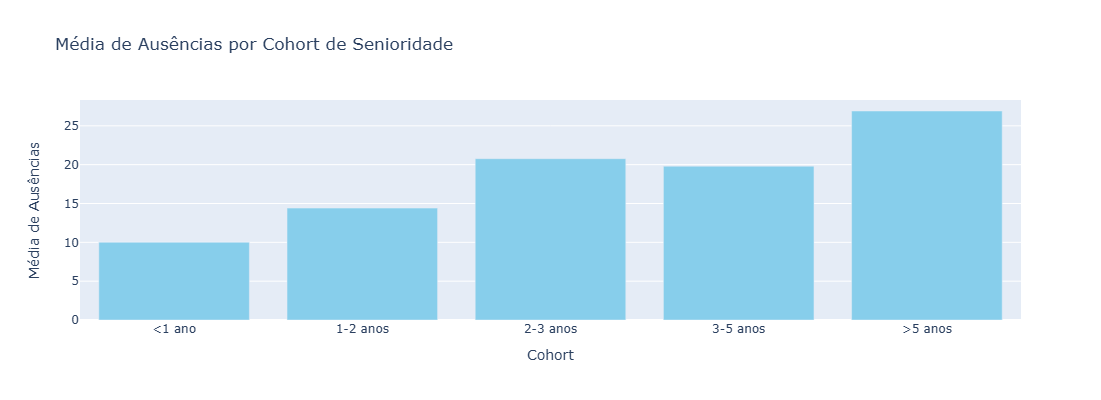

In [83]:
# 7.1 Análise por Cohort (baseado em DtActivacao REAL)
print('=== ANÁLISE POR COHORT (SENIORIDADE) ===\n')

if 'DtActivacao' not in df.columns:
    print('❌ Campo "DtActivacao" não encontrado!')
    print('   Análise de cohorts requer data de ativação real.')
    print('   Pulando esta seção.')
else:
    print('✓ Campo DtActivacao encontrado')

    # Preparar dados
    df_cohort = df[['login_colaborador', 'nome_colaborador', 'DtActivacao', 'Data', 'Nivel 1']].copy()
    df_cohort['DtActivacao'] = pd.to_datetime(df_cohort['DtActivacao'], errors='coerce')
    df_cohort = df_cohort.dropna(subset=['DtActivacao'])

    print(f'Colaboradores com DtActivacao válida: {df_cohort["login_colaborador"].nunique():,}')

    # Calcular senioridade
    data_ref = df_cohort['Data'].max()
    df_cohort['senioridade_anos'] = (data_ref - df_cohort['DtActivacao']).dt.days / 365.25

    # Criar cohorts
    df_cohort['cohort'] = pd.cut(
        df_cohort['senioridade_anos'],
        bins=[0, 1, 2, 3, 5, 100],
        labels=['<1 ano', '1-2 anos', '2-3 anos', '3-5 anos', '>5 anos']
    )

    # Expandir e filtrar ausências
    df_cohort_exp = df_cohort.copy()
    if isinstance(df_cohort_exp['Nivel 1'].iloc[0], list):
        df_cohort_exp = df_cohort_exp.explode('Nivel 1')

    df_cohort_abs = df_cohort_exp[
        df_cohort_exp['Nivel 1'].isin(['Falta Justificada', 'Falta Injustificada', 'Ausência'])
    ]

    # Estatísticas
    cohort_stats = df_cohort_abs.groupby('cohort').agg({
        'login_colaborador': 'nunique',
        'Data': 'count'
    }).rename(columns={'login_colaborador': 'num_colaboradores', 'Data': 'total_ausencias'})

    cohort_stats['media_ausencias'] = cohort_stats['total_ausencias'] / cohort_stats['num_colaboradores']

    print('\n📊 Absentismo por Cohort:')
    print(cohort_stats)

    # Visualização
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=cohort_stats.index,
        y=cohort_stats['media_ausencias'],
        marker_color='skyblue'
    ))
    fig.update_layout(
        title='Média de Ausências por Cohort de Senioridade',
        xaxis_title='Cohort',
        yaxis_title='Média de Ausências',
        height=400
    )
    fig.show()


---

## 8. CLUSTERING DE PERFIS DE ABSENTISMO

**Objetivo**: Segmentar colaboradores em grupos homogéneos por comportamento de absentismo.

**Features para clustering**:
- Número de spells (frequência)
- Total de dias ausentes
- Duração média de spell
- Bradford score
- Proporção de short-term spells

**Algoritmo**: K-Means (3-5 clusters típicos)

Preparando features para clustering...

✓ Features preparadas: (2369, 5)

Calculando Elbow Method (K=2 a K=8)...


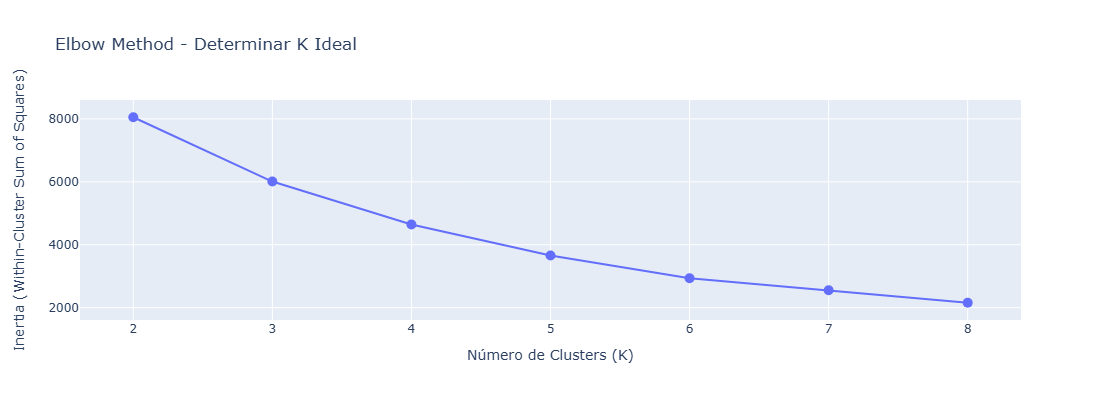


Aplicando K-Means com K=4...

✓ Clusters atribuídos

Distribuição por cluster:
cluster
0    1831
1     504
2      10
3      24
Name: count, dtype: int64


In [85]:
# 8.1 Preparar dados para clustering
print('Preparando features para clustering...')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Selecionar features
features_clustering = [
    'num_spells',
    'total_dias_ausentes', 
    'mean_spell_duration',
    'bradford_score',
    'num_short_term_spells'
]

df_cluster = df_bradford[['login_colaborador', 'nome_colaborador'] + features_clustering].copy()

# Normalizar features (importante para K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features_clustering])

print(f'\n✓ Features preparadas: {X_scaled.shape}')

# Determinar número ideal de clusters (Elbow Method)
print('\nCalculando Elbow Method (K=2 a K=8)...')
inertias = []
K_range = range(2, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Visualizar Elbow
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(K_range),
    y=inertias,
    mode='lines+markers',
    marker=dict(size=10)
))
fig.update_layout(
    title='Elbow Method - Determinar K Ideal',
    xaxis_title='Número de Clusters (K)',
    yaxis_title='Inertia (Within-Cluster Sum of Squares)',
    height=400
)
fig.show()

# Aplicar K-Means com K=4 (típico para absentismo: baixo/moderado/alto/muito alto)
K_optimal = 4
print(f'\nAplicando K-Means com K={K_optimal}...')

kmeans = KMeans(n_clusters=K_optimal, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

print(f'\n✓ Clusters atribuídos')
print(f'\nDistribuição por cluster:')
print(df_cluster['cluster'].value_counts().sort_index())


Validando número de clusters com Silhouette Score...

K=2: Silhouette Score = 0.627
K=3: Silhouette Score = 0.569
K=4: Silhouette Score = 0.577
K=5: Silhouette Score = 0.516
K=6: Silhouette Score = 0.508
K=7: Silhouette Score = 0.500
K=8: Silhouette Score = 0.472
K=9: Silhouette Score = 0.470
K=10: Silhouette Score = 0.477


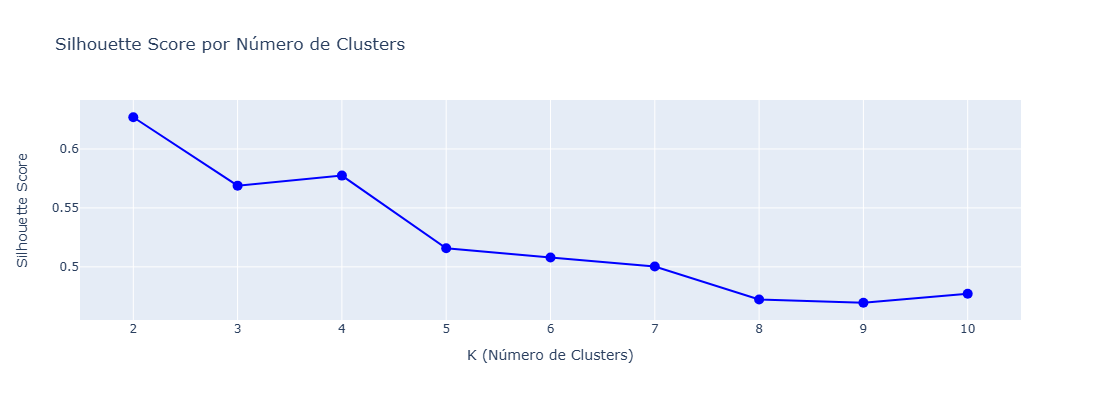


💡 Melhor K por Silhouette: 2 (score=0.627)
   Usando K=2 para clustering final


In [87]:
# 8.2 Validação com Silhouette Score
print('\nValidando número de clusters com Silhouette Score...\n')

from sklearn.metrics import silhouette_score

silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_test = kmeans_test.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels_test)
    silhouette_scores.append(score)
    print(f'K={k}: Silhouette Score = {score:.3f}')

# Visualizar
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(K_range),
    y=silhouette_scores,
    mode='lines+markers',
    marker=dict(size=10, color='blue'),
    line=dict(width=2)
))
fig.update_layout(
    title='Silhouette Score por Número de Clusters',
    xaxis_title='K (Número de Clusters)',
    yaxis_title='Silhouette Score',
    height=400
)
fig.show()

best_k = list(K_range)[silhouette_scores.index(max(silhouette_scores))]
print(f'\n💡 Melhor K por Silhouette: {best_k} (score={max(silhouette_scores):.3f})')

# Usar o melhor K
K_optimal = best_k
print(f'   Usando K={K_optimal} para clustering final')


In [91]:
# 8.2 Interpretar clusters - Calcular médias por cluster
print('\n=== CARACTERIZAÇÃO DOS CLUSTERS ===')

cluster_profiles = df_cluster.groupby('cluster')[features_clustering].mean()

# Ordenar por bradford_score (do menor ao maior)
cluster_profiles = cluster_profiles.sort_values('bradford_score')

# Renomear clusters de forma interpretável
cluster_mapping = {}
for idx, (cluster_id, row) in enumerate(cluster_profiles.iterrows()):
    if idx == 0:
        cluster_mapping[cluster_id] = '1. BAIXO Absentismo'
    elif idx == 1:
        cluster_mapping[cluster_id] = '2. MODERADO Absentismo'
    elif idx == 2:
        cluster_mapping[cluster_id] = '3. ALTO Absentismo'
    else:
        cluster_mapping[cluster_id] = '4. MUITO ALTO Absentismo'

df_cluster['cluster_nome'] = df_cluster['cluster'].map(cluster_mapping)

# Exibir perfis
print('\nPERFIL MÉDIO POR CLUSTER:\n')
for cluster_id, row in cluster_profiles.iterrows():
    cluster_nome = cluster_mapping[cluster_id]
    n_colab = (df_cluster['cluster'] == cluster_id).sum()
    
    print(f'{cluster_nome} (n={n_colab})')
    print(f'   Nº Spells: {row["num_spells"]:.2f}')
    print(f'   Total Dias Ausentes: {row["total_dias_ausentes"]:.2f}')
    print(f'   Duração Média Spell: {row["mean_spell_duration"]:.2f} dias')
    print(f'   Bradford Score: {row["bradford_score"]:.2f}')
    print(f'   Short-term Spells: {row["num_short_term_spells"]:.2f}')
    print()

# Exportar colaboradores com clusters
df_cluster_export = df_cluster[[
    'nome_colaborador', 'cluster_nome', 'num_spells', 'total_dias_ausentes',
    'mean_spell_duration', 'bradford_score'
]].sort_values(['cluster_nome', 'bradford_score'], ascending=[True, False])

df_cluster_export.to_excel('colaboradores_clusters_absentismo.xlsx', index=False)
print('✓ Clusters exportados para: colaboradores_clusters_absentismo.xlsx')


=== CARACTERIZAÇÃO DOS CLUSTERS ===

PERFIL MÉDIO POR CLUSTER:

1. BAIXO Absentismo (n=1831)
   Nº Spells: 3.33
   Total Dias Ausentes: 9.51
   Duração Média Spell: 3.00 dias
   Bradford Score: 215.46
   Short-term Spells: 2.75

2. MODERADO Absentismo (n=504)
   Nº Spells: 11.51
   Total Dias Ausentes: 37.84
   Duração Média Spell: 3.39 dias
   Bradford Score: 6569.33
   Short-term Spells: 9.65

3. ALTO Absentismo (n=24)
   Nº Spells: 5.75
   Total Dias Ausentes: 191.96
   Duração Média Spell: 57.40 dias
   Bradford Score: 12491.83
   Short-term Spells: 3.50

4. MUITO ALTO Absentismo (n=10)
   Nº Spells: 28.70
   Total Dias Ausentes: 186.90
   Duração Média Spell: 7.19 dias
   Bradford Score: 144835.40
   Short-term Spells: 19.60

✓ Clusters exportados para: colaboradores_clusters_absentismo.xlsx



Visualizando clusters em 2D (PCA)...
Variância explicada: PC1=56.74%, PC2=27.14%


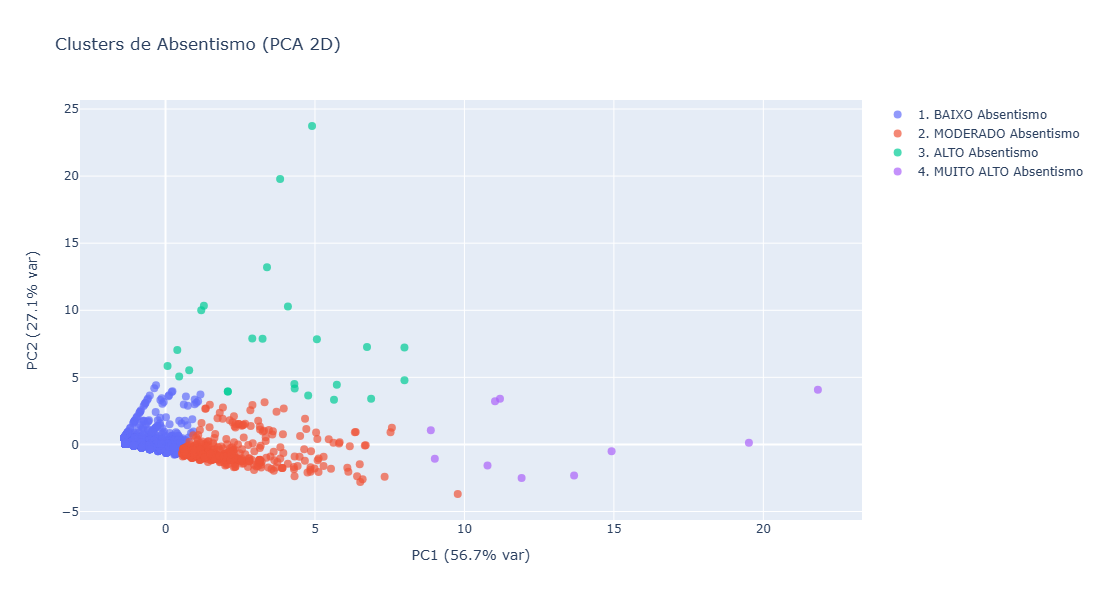

In [93]:
# 8.3 Visualizar clusters em 2D (PCA)
print('\nVisualizando clusters em 2D (PCA)...')

from sklearn.decomposition import PCA

# Reduzir para 2 dimensões
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_cluster['PC1'] = X_pca[:, 0]
df_cluster['PC2'] = X_pca[:, 1]

print(f'Variância explicada: PC1={pca.explained_variance_ratio_[0]*100:.2f}%, PC2={pca.explained_variance_ratio_[1]*100:.2f}%')

# Scatter plot
fig = go.Figure()

for cluster_nome in sorted(df_cluster['cluster_nome'].unique()):
    df_temp = df_cluster[df_cluster['cluster_nome'] == cluster_nome]
    
    fig.add_trace(go.Scatter(
        x=df_temp['PC1'],
        y=df_temp['PC2'],
        mode='markers',
        name=cluster_nome,
        text=df_temp['nome_colaborador'],
        marker=dict(size=8, opacity=0.7),
        hovertemplate='<b>%{text}</b><br>PC1: %{x:.2f}<br>PC2: %{y:.2f}<extra></extra>'
    ))

fig.update_layout(
    title='Clusters de Absentismo (PCA 2D)',
    xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)',
    yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)',
    height=600
)

fig.show()

---

## 9. NETWORK ANALYSIS (Coincidências de Ausências)

**Objetivo**: Detetar padrões de ausências **simultâneas** que possam indicar:
- Eventos locais (gripe, problema na operação)
- Problemas de equipa
- Coincidências suspeitas

**Método**: Identificar dias com múltiplos colaboradores ausentes na mesma operação.

In [95]:
# 9.1 Preparar dados: APENAS colaboradores ativos
print('=== NETWORK ANALYSIS: CO-AUSÊNCIAS ===\n')

# Filtrar apenas ausências de colaboradores ativos
if 'Activo?' in df.columns:
    df_network = df[
        (df['Nivel 1'].isin(['Falta Justificada', 'Falta Injustificada', 'Ausência'])) &
        (df['Activo?'].isin(['Sim', True, 'sim', 'S']))
    ].copy()
    print(f'✓ Filtrado para colaboradores ativos')
else:
    df_network = df[
        df['Nivel 1'].isin(['Falta Justificada', 'Falta Injustificada', 'Ausência'])
    ].copy()
    print(f'⚠️  Campo Activo? não encontrado - usando todos')

print(f'Registos: {len(df_network):,}')
print(f'Colaboradores: {df_network["login_colaborador"].nunique():,}')
print(f'Período: {df_network["Data"].min().date()} até {df_network["Data"].max().date()}')

=== NETWORK ANALYSIS: CO-AUSÊNCIAS ===

✓ Filtrado para colaboradores ativos
Registos: 29,922
Colaboradores: 1,611
Período: 2024-01-01 até 2025-06-30


In [103]:
# 9.2 Calcular co-ausências e métricas de overlap
print('\nCalculando co-ausências por pares...\n')

# Criar dicionário: colaborador -> set de dias
print('   Criando dicionário de dias por colaborador...')
colab_dias = {}
for colab in df_network['login_colaborador'].unique():
    dias_set = set(df_network[df_network['login_colaborador'] == colab]['Data'])
    colab_dias[colab] = dias_set

colaboradores = list(colab_dias.keys())
print(f'   Colaboradores: {len(colaboradores):,}')

# Calcular overlaps entre todos os pares
print('   Calculando overlaps entre pares...')
pares = []

for i, colab_i in enumerate(colaboradores):
    if i % 200 == 0:
        print(f'      Processado {i}/{len(colaboradores)}...')

    dias_i = colab_dias[colab_i]

    for colab_j in colaboradores[i+1:]:
        dias_j = colab_dias[colab_j]

        # Co-ausências = interseção
        cooccur = len(dias_i & dias_j)

        if cooccur >= 3:  # Mínimo 3 dias juntos
            # Overlap em relação ao menor
            # Jaccard Index = interseção / união
            union_size = len(dias_i | dias_j)
            jaccard = cooccur / union_size if union_size > 0 else 0

            pares.append({
                'colab_i': colab_i,
                'colab_j': colab_j,
                'cooccur': cooccur,
                'dias_i': len(dias_i),
                'dias_j': len(dias_j),
                'jaccard': jaccard
            })

df_pares = pd.DataFrame(pares)

print(f'\n✓ Encontrados {len(df_pares):,} pares com ≥3 co-ausências')

# Adicionar nomes
df_pares = df_pares.merge(
    df[['login_colaborador', 'nome_colaborador']].drop_duplicates(),
    left_on='colab_i', right_on='login_colaborador'
).rename(columns={'nome_colaborador': 'nome_i'}).drop('login_colaborador', axis=1)

df_pares = df_pares.merge(
    df[['login_colaborador', 'nome_colaborador']].drop_duplicates(),
    left_on='colab_j', right_on='login_colaborador'
).rename(columns={'nome_colaborador': 'nome_j'}).drop('login_colaborador', axis=1)

# Ordenar por Jaccard Index
df_pares['overlap_pct'] = 100 * df_pares['cooccur'] / df_pares[['dias_i','dias_j']].min(axis=1)
df_pares = df_pares.sort_values('overlap_pct', ascending=False).reset_index(drop=True)




Calculando co-ausências por pares...

   Criando dicionário de dias por colaborador...
   Colaboradores: 1,611
   Calculando overlaps entre pares...
      Processado 0/1611...
      Processado 200/1611...
      Processado 400/1611...
      Processado 600/1611...
      Processado 800/1611...
      Processado 1000/1611...
      Processado 1200/1611...
      Processado 1400/1611...
      Processado 1600/1611...

✓ Encontrados 95,214 pares com ≥3 co-ausências



ANÁLISE DE DISTRIBUIÇÃO:

📊 Estatísticas de Overlap:
   Média: 4441.2%
   Mediana: 3750.0%
   P75: 6000.0%
   P90: 9333.3%
   P95: 10000.0%
   Máximo: 10000.0%


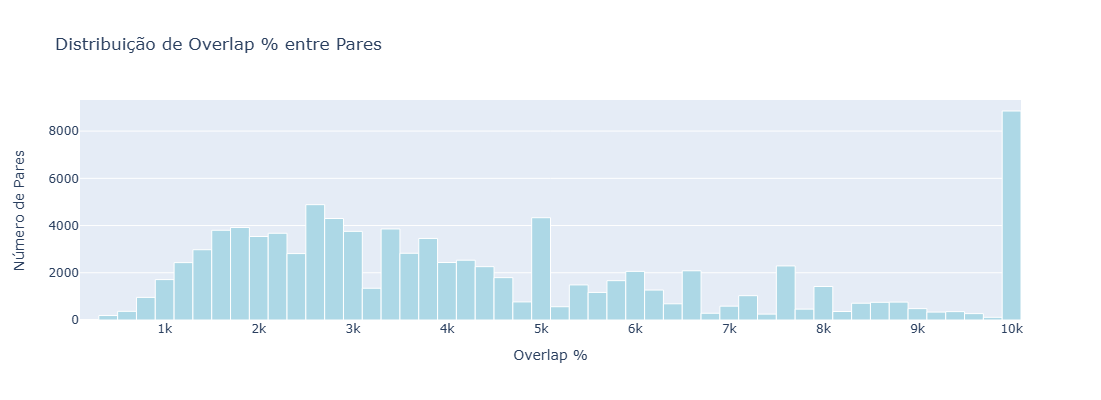


💡 Threshold escolhido (P90): 9333.3%
   Pares significativos: 9,570


In [105]:
# 9.3 Análise de distribuição para escolher threshold
print('\nANÁLISE DE DISTRIBUIÇÃO:\n')

print(f'📊 Estatísticas de Overlap:')
print(f'   Média: {df_pares["overlap_pct"].mean()*100:.1f}%')
print(f'   Mediana: {df_pares["overlap_pct"].median()*100:.1f}%')
print(f'   P75: {df_pares["overlap_pct"].quantile(0.75)*100:.1f}%')
print(f'   P90: {df_pares["overlap_pct"].quantile(0.90)*100:.1f}%')
print(f'   P95: {df_pares["overlap_pct"].quantile(0.95)*100:.1f}%')
print(f'   Máximo: {df_pares["overlap_pct"].max()*100:.1f}%')

# Histograma
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_pares['overlap_pct'] * 100,
    nbinsx=50,
    marker_color='lightblue',
    marker_line_color='white',
    marker_line_width=1
))

fig.update_layout(
    title='Distribuição de Overlap % entre Pares',
    xaxis_title='Overlap %',
    yaxis_title='Número de Pares',
    height=400
)

fig.show()

# Escolher threshold (P90)
threshold = df_pares['overlap_pct'].quantile(0.90)
print(f'\n💡 Threshold escolhido (P90): {threshold*100:.1f}%')

df_pares_sig = df_pares[df_pares['overlap_pct'] >= threshold].copy()
print(f'   Pares significativos: {len(df_pares_sig):,}')

In [107]:
# 9.4 Top pares com maior overlap
print('\n🔝 TOP 20 PARES POR OVERLAP:\n')

for idx, row in df_pares_sig.head(20).iterrows():
    print(f"{idx+1:2d}. {row['nome_i'][:30]:30s} + {row['nome_j'][:30]:30s}")
    print(f"    Co-ausências: {row['cooccur']:3d} | Total i: {row['dias_i']:3d} | Total j: {row['dias_j']:3d} | Overlap: {row['overlap_pct']*100:5.1f}%")

# Exportar
df_pares_sig.to_excel('network_pares_significativos.xlsx', index=False)
print('\n✓ Exportado: network_pares_significativos.xlsx')


🔝 TOP 20 PARES POR OVERLAP:

 1. Neusa Priscila de Assis Soba   + Valdmiro João Congo           
    Co-ausências:   3 | Total i:  22 | Total j:   3 | Overlap: 10000.0%
 2. Edino Eudóixo Alves de Almeida + Adelina Miranda               
    Co-ausências:  24 | Total i:  24 | Total j: 281 | Overlap: 10000.0%
 3. Albertina Nvuama Neto          + Adelina Miranda               
    Co-ausências:  27 | Total i:  27 | Total j: 281 | Overlap: 10000.0%
 4. Albertina Nvuama Neto          + Euritece Palhares             
    Co-ausências:  27 | Total i:  27 | Total j:  69 | Overlap: 10000.0%
 5. Albertina Nvuama Neto          + Elisa Abraão                  
    Co-ausências:  27 | Total i:  27 | Total j:  53 | Overlap: 10000.0%
 6. Albertina Nvuama Neto          + Ronalda Almeida               
    Co-ausências:  27 | Total i:  27 | Total j:  56 | Overlap: 10000.0%
 7. Albertina Nvuama Neto          + Francisco Pedro               
    Co-ausências:   5 | Total i:  27 | Total j:   5 | Overlap:


Criando visualização da rede...

Visualizando top 50 pares
Nós: 45, Arestas: 50


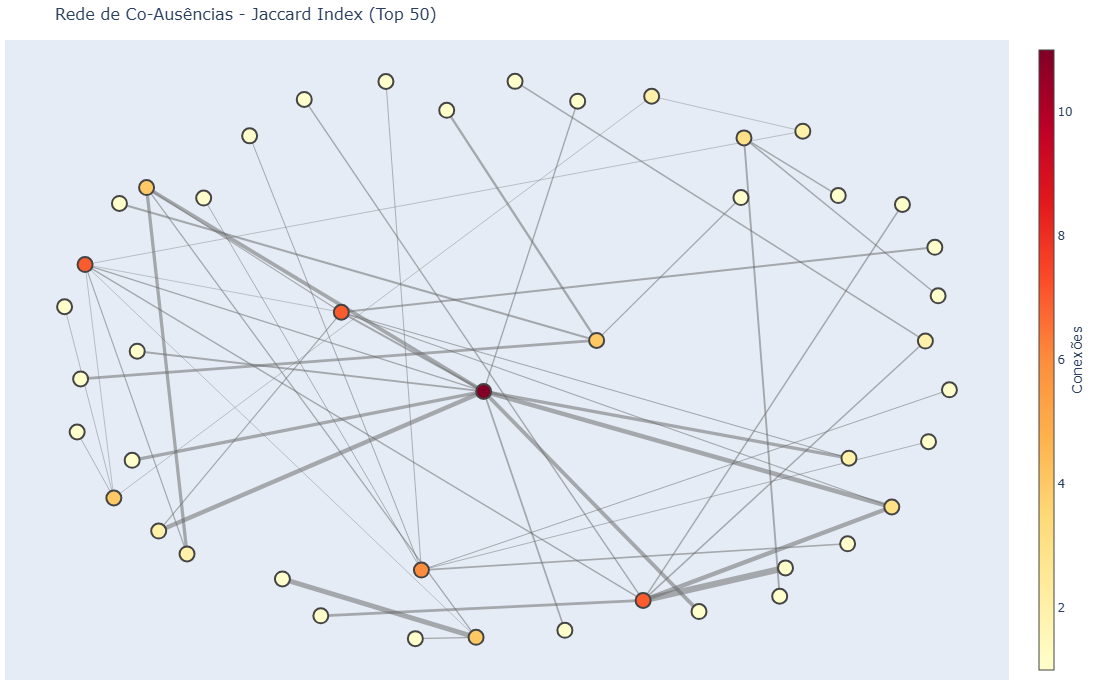


✓ Rede visualizada com espessura variável


In [109]:
# 9.5 Visualização da Rede (espessura variável)
print('\nCriando visualização da rede...\n')

import networkx as nx

# Limitar a top N pares
TOP_N = min(50, len(df_pares_sig))
df_viz = df_pares_sig.head(TOP_N)

print(f'Visualizando top {TOP_N} pares')

# Criar grafo
G = nx.Graph()

for _, row in df_viz.iterrows():
    G.add_edge(
        row['colab_i'],
        row['colab_j'],
        weight=row['jaccard'],
        cooccur=row['cooccur']
    )

print(f'Nós: {G.number_of_nodes()}, Arestas: {G.number_of_edges()}')

# Layout
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

# ARESTAS COM ESPESSURA VARIÁVEL
edge_traces = []

for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]

    # Espessura proporcional ao Jaccard
    weight = edge[2]['weight']
    line_width = 0.5 + weight * 8  # 0.5 a 8.5

    edge_trace = go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        line=dict(width=line_width, color='rgba(100,100,100,0.5)'),
        hoverinfo='none',
        mode='lines'
    )
    edge_traces.append(edge_trace)

# Nós
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlOrRd',
        size=15,
        colorbar=dict(
            thickness=15,
            title='Conexões',
            xanchor='left',
            titleside='right'
        ),
        line_width=2
    )
)

# Colorir por número de conexões
node_adjacencies = []
node_text = []

for node in G.nodes():
    adjacencies = list(G.neighbors(node))
    node_adjacencies.append(len(adjacencies))

    nome = df[df['login_colaborador'] == node]['nome_colaborador']
    nome_str = nome.iloc[0] if len(nome) > 0 else node

    node_text.append(f'{nome_str}<br>Conexões: {len(adjacencies)}')

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

# Figura
fig = go.Figure(
    data=edge_traces + [node_trace],
    layout=go.Layout(
        title=f'Rede de Co-Ausências - Jaccard Index (Top {TOP_N})',
        titlefont_size=16,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        height=700,
        width=1000
    )
)

fig.show()

print('\n✓ Rede visualizada com espessura variável')


---

## 9B. ANÁLISE DE SAZONALIDADE

Identificar padrões temporais e sazonais nas ausências.


=== ANÁLISE DE SAZONALIDADE ===



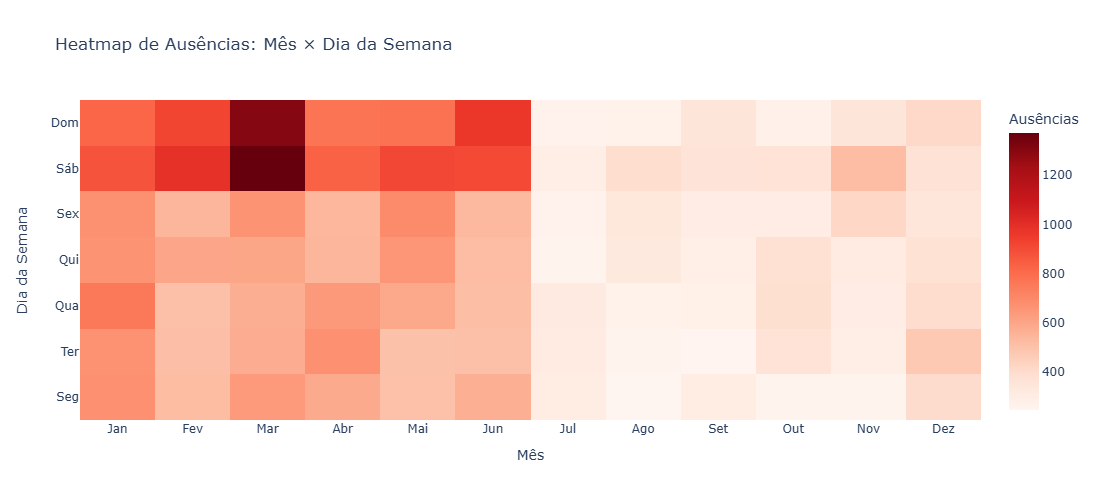

✓ Heatmap criado


In [111]:
# 9B.1 Heatmap: Mês × Dia da Semana
print('=== ANÁLISE DE SAZONALIDADE ===\n')

# Preparar dados - apenas ausências
df_season = df.copy()

# Expandir Nivel 1 se for lista
if isinstance(df_season['Nivel 1'].iloc[0], list):
    df_season = df_season.explode('Nivel 1')

df_season = df_season[
    df_season['Nivel 1'].isin(['Falta Justificada', 'Falta Injustificada', 'Ausência'])
].copy()

# Extrair componentes temporais
df_season['mes'] = df_season['Data'].dt.month
df_season['dia_semana'] = df_season['Data'].dt.dayofweek  # 0=Segunda
df_season['mes_nome'] = df_season['Data'].dt.strftime('%b')
df_season['dia_nome'] = df_season['Data'].dt.strftime('%a')

# Criar pivot
heatmap_data = df_season.groupby(['mes', 'dia_semana']).size().reset_index(name='count')
heatmap_pivot = heatmap_data.pivot(index='dia_semana', columns='mes', values='count').fillna(0)

# Labels
dia_nomes = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
mes_nomes = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

# Heatmap
fig = go.Figure(data=go.Heatmap(
    z=heatmap_pivot.values,
    x=[mes_nomes[int(i)-1] for i in heatmap_pivot.columns],
    y=dia_nomes,
    colorscale='Reds',
    colorbar=dict(title='Ausências')
))

fig.update_layout(
    title='Heatmap de Ausências: Mês × Dia da Semana',
    xaxis_title='Mês',
    yaxis_title='Dia da Semana',
    height=500,
    width=1000
)

fig.show()

print('✓ Heatmap criado')



Decompondo série temporal...

Período: 2024-01-01 até 2025-06-30
Total dias: 547


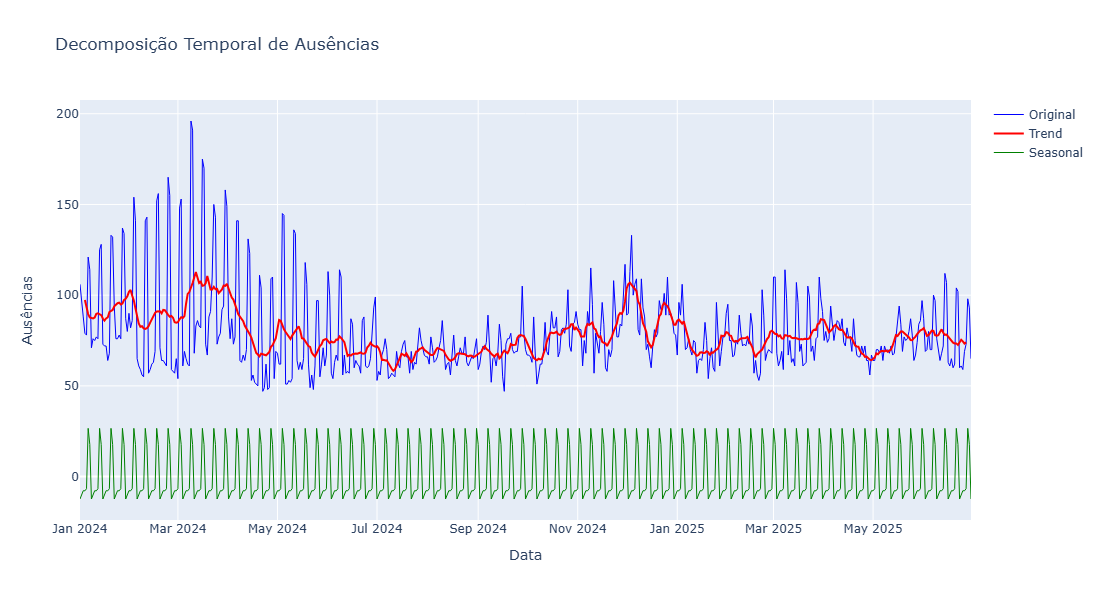


✓ Decomposição criada

📊 Insights:
   Média: 78.5 ausências/dia
   Tendência final: 77.4
   Amplitude sazonal: 38.9


In [113]:
# 9B.2 Decomposição Temporal (Trend + Seasonal)
print('\nDecompondo série temporal...\n')

from statsmodels.tsa.seasonal import seasonal_decompose

# Série temporal diária
ts_data = df_season.groupby('Data').size().reset_index(name='ausencias')
ts_data = ts_data.set_index('Data').sort_index()
ts_data = ts_data.asfreq('D', fill_value=0)

print(f'Período: {ts_data.index.min().date()} até {ts_data.index.max().date()}')
print(f'Total dias: {len(ts_data)}')

try:
    # Decomposição (período semanal = 7)
    decomposition = seasonal_decompose(ts_data['ausencias'], model='additive', period=7)

    # Visualizar
    fig = go.Figure()

    # Original
    fig.add_trace(go.Scatter(
        x=ts_data.index, y=ts_data['ausencias'],
        mode='lines', name='Original',
        line=dict(color='blue', width=1)
    ))

    # Trend
    fig.add_trace(go.Scatter(
        x=ts_data.index, y=decomposition.trend,
        mode='lines', name='Trend',
        line=dict(color='red', width=2)
    ))

    # Seasonal
    fig.add_trace(go.Scatter(
        x=ts_data.index, y=decomposition.seasonal,
        mode='lines', name='Seasonal',
        line=dict(color='green', width=1)
    ))

    fig.update_layout(
        title='Decomposição Temporal de Ausências',
        xaxis_title='Data',
        yaxis_title='Ausências',
        height=600,
        hovermode='x unified'
    )

    fig.show()

    print('\n✓ Decomposição criada')
    print(f'\n📊 Insights:')
    print(f'   Média: {ts_data["ausencias"].mean():.1f} ausências/dia')
    print(f'   Tendência final: {decomposition.trend.dropna().iloc[-30:].mean():.1f}')
    print(f'   Amplitude sazonal: {decomposition.seasonal.max() - decomposition.seasonal.min():.1f}')

except Exception as e:
    print(f'⚠️  Erro na decomposição: {e}')


---

## 10. EVENT DETECTION & ANOMALY DETECTION

**Objetivo**: Monitorar evolução temporal e detetar **mudanças de padrão** (changepoints).

**Métodos**:
- **U-Chart**: Control chart para taxa por unidade de tempo
- **Rolling statistics**: Média móvel e desvio padrão
- **Anomaly detection**: Períodos estatisticamente anómalos

Criando U-Chart (control chart)...

📊 U-CHART
   Semanas analisadas: 79
   Taxa média: 0.316 ausências/colaborador/semana
   Semanas FORA DE CONTROLE: 32 (40.51%)


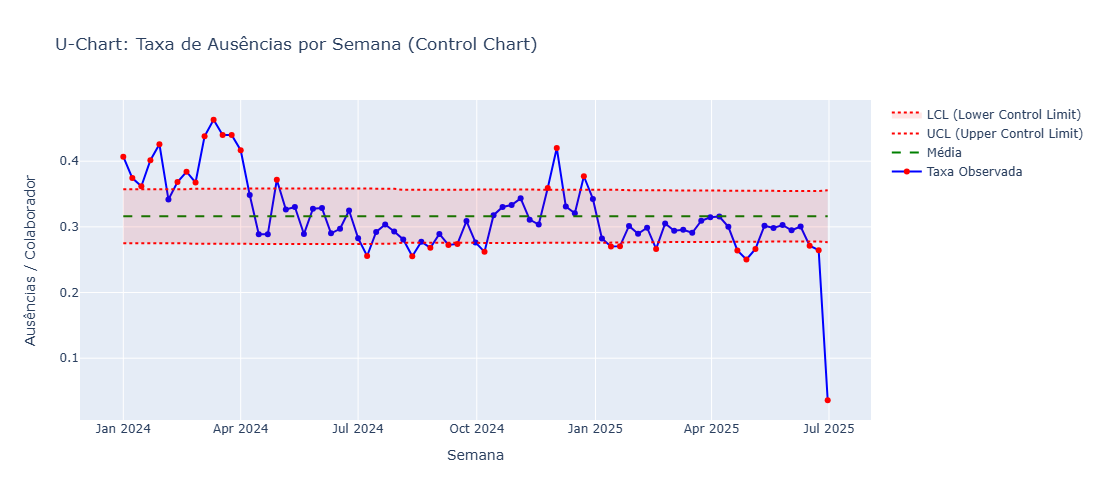


Semanas fora de controle:
               semana  num_ausencias  colaboradores_ativos  taxa_ausencia_colab      ucl
2024-01-01/2024-01-07            681                  1674             0.406810 0.357402
2024-01-08/2024-01-14            628                  1678             0.374255 0.357353
2024-01-15/2024-01-21            614                  1697             0.361815 0.357122
2024-01-22/2024-01-28            671                  1671             0.401556 0.357439
2024-01-29/2024-02-04            720                  1691             0.425784 0.357194
2024-02-12/2024-02-18            618                  1678             0.368296 0.357353
2024-02-19/2024-02-25            642                  1672             0.383971 0.357427
2024-02-26/2024-03-03            594                  1616             0.367574 0.358135
2024-03-04/2024-03-10            705                  1610             0.437888 0.358213
2024-03-11/2024-03-17            747                  1613             0.463112 0.3

In [115]:
# 10.1 U-Chart - Taxa de ausências por semana
print('Criando U-Chart (control chart)...')

# Agrupar por semana
df_ausencias['semana'] = df_ausencias['Data'].dt.to_period('W').astype(str)

ausencias_semana = df_ausencias.groupby('semana').size().reset_index(name='num_ausencias')
ausencias_semana['semana_dt'] = pd.to_datetime(ausencias_semana['semana'].str.split('/').str[0])

# Calcular colaboradores ativos por semana (para normalizar)
colab_semana = df.groupby(df['Data'].dt.to_period('W').astype(str))['login_colaborador'].nunique()
ausencias_semana['colaboradores_ativos'] = ausencias_semana['semana'].map(colab_semana)

# Taxa de ausências por colaborador
ausencias_semana['taxa_ausencia_colab'] = (
    ausencias_semana['num_ausencias'] / ausencias_semana['colaboradores_ativos']
)

# Limites de controle (U-chart)
# UCL/LCL = mean ± 3*sqrt(mean/n)
mean_taxa = ausencias_semana['taxa_ausencia_colab'].mean()
ausencias_semana['ucl'] = mean_taxa + 3 * np.sqrt(mean_taxa / ausencias_semana['colaboradores_ativos'])
ausencias_semana['lcl'] = mean_taxa - 3 * np.sqrt(mean_taxa / ausencias_semana['colaboradores_ativos'])
ausencias_semana['lcl'] = ausencias_semana['lcl'].clip(lower=0)

# Identificar semanas fora de controle
ausencias_semana['out_of_control'] = (
    (ausencias_semana['taxa_ausencia_colab'] > ausencias_semana['ucl']) |
    (ausencias_semana['taxa_ausencia_colab'] < ausencias_semana['lcl'])
)

n_out = ausencias_semana['out_of_control'].sum()
print(f'\n📊 U-CHART')
print(f'   Semanas analisadas: {len(ausencias_semana)}')
print(f'   Taxa média: {mean_taxa:.3f} ausências/colaborador/semana')
print(f'   Semanas FORA DE CONTROLE: {n_out} ({n_out/len(ausencias_semana)*100:.2f}%)')

# Visualizar U-Chart
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ausencias_semana['semana_dt'],
    y=ausencias_semana['taxa_ausencia_colab'],
    mode='lines+markers',
    name='Taxa Observada',
    line=dict(color='blue'),
    marker=dict(
        size=6,
        color=ausencias_semana['out_of_control'].map({True: 'red', False: 'blue'})
    )
))

fig.add_trace(go.Scatter(
    x=ausencias_semana['semana_dt'],
    y=[mean_taxa] * len(ausencias_semana),
    mode='lines',
    name='Média',
    line=dict(color='green', dash='dash')
))

fig.add_trace(go.Scatter(
    x=ausencias_semana['semana_dt'],
    y=ausencias_semana['ucl'],
    mode='lines',
    name='UCL (Upper Control Limit)',
    line=dict(color='red', dash='dot')
))

fig.add_trace(go.Scatter(
    x=ausencias_semana['semana_dt'],
    y=ausencias_semana['lcl'],
    mode='lines',
    name='LCL (Lower Control Limit)',
    line=dict(color='red', dash='dot'),
    fill='tonexty',
    fillcolor='rgba(255,0,0,0.1)'
))

fig.update_layout(
    title='U-Chart: Taxa de Ausências por Semana (Control Chart)',
    xaxis_title='Semana',
    yaxis_title='Ausências / Colaborador',
    height=500,
    hovermode='x unified'
)

fig.show()

if n_out > 0:
    print(f'\nSemanas fora de controle:')
    print(ausencias_semana[ausencias_semana['out_of_control']][
        ['semana', 'num_ausencias', 'colaboradores_ativos', 'taxa_ausencia_colab', 'ucl']
    ].to_string(index=False))

---

## 11. VISUALIZAÇÕES AVANÇADAS

### 11.1 Calendar Heatmap - Visualizar dias críticos

Criando calendar heatmap...

Criando heatmap para: Unitel Alpha


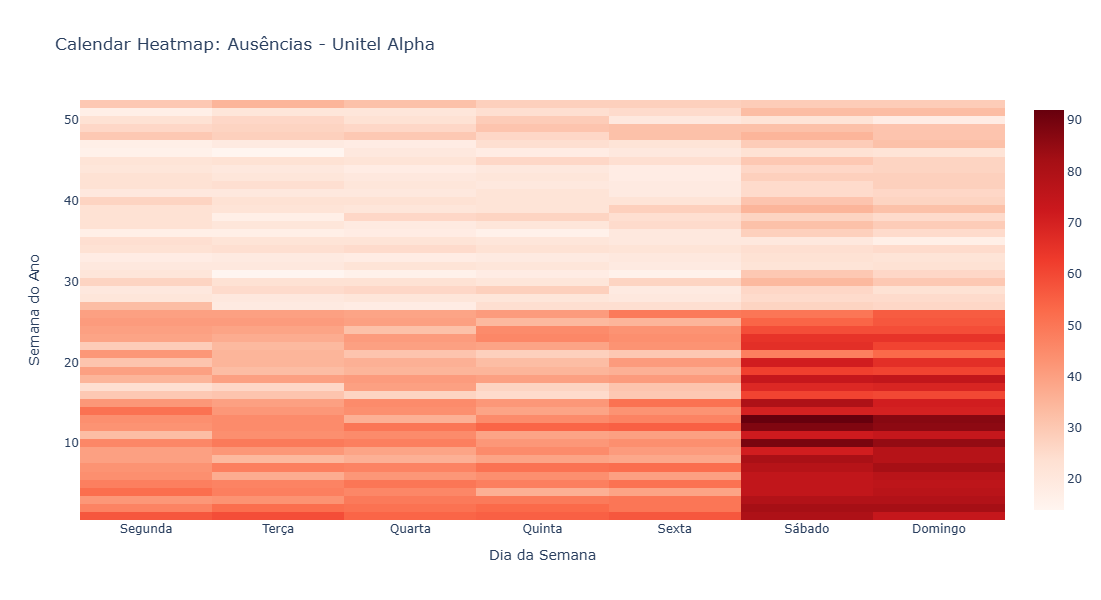


Criando heatmap para: TAAG


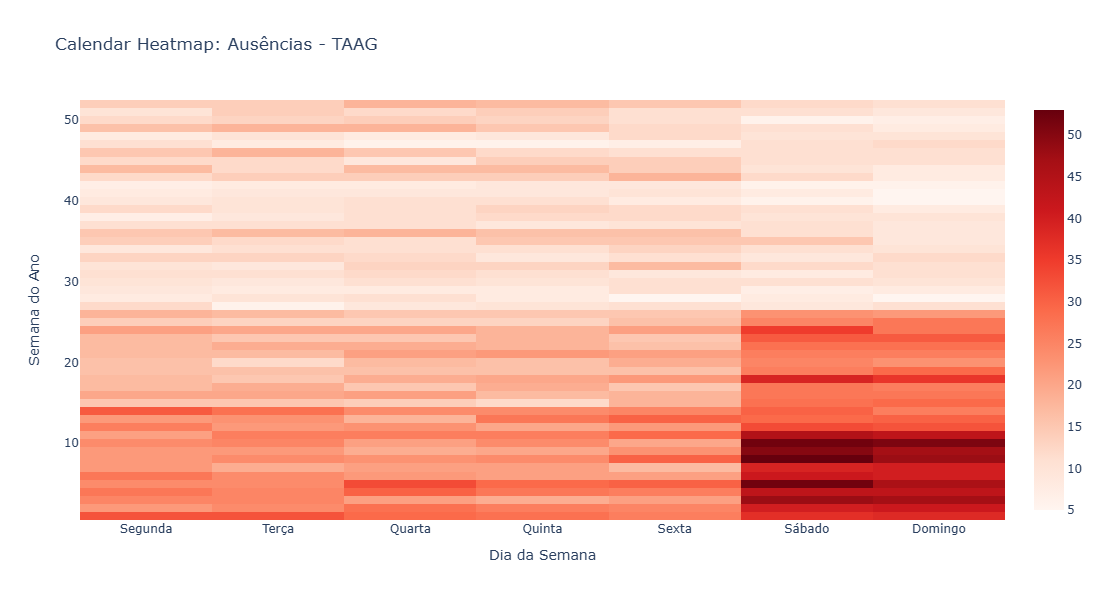


Criando heatmap para: ZAP_DTH


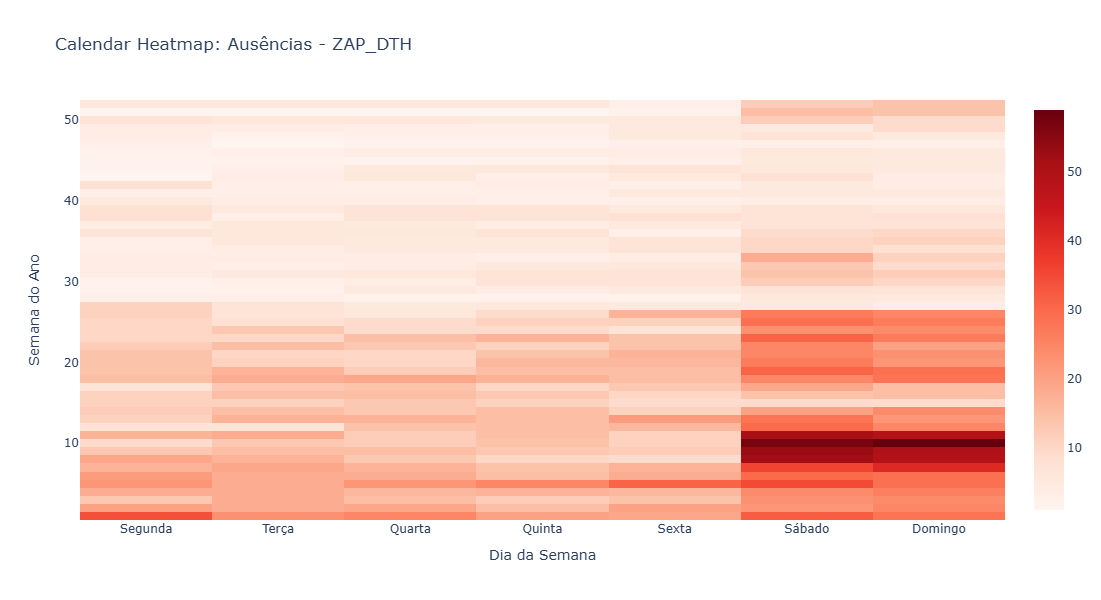

In [117]:
# 11.1 Calendar Heatmap por Operação
print('Criando calendar heatmap...')

if 'operacao' in df_ausencias.columns:
    # Selecionar top 3 operações por número de ausências
    top_operacoes = df_ausencias['operacao'].value_counts().head(3).index.tolist()
    
    for operacao in top_operacoes:
        print(f'\nCriando heatmap para: {operacao}')
        
        df_op = df_ausencias[df_ausencias['operacao'] == operacao].copy()
        
        # Contar ausências por dia
        ausencias_dia = df_op.groupby('Data').size().reset_index(name='num_ausencias')
        
        # Adicionar features para heatmap
        ausencias_dia['ano'] = ausencias_dia['Data'].dt.year
        ausencias_dia['semana'] = ausencias_dia['Data'].dt.isocalendar().week
        ausencias_dia['dia_semana'] = ausencias_dia['Data'].dt.dayofweek
        
        # Pivot para heatmap: semanas x dias da semana
        pivot = ausencias_dia.pivot_table(
            index='semana',
            columns='dia_semana',
            values='num_ausencias',
            aggfunc='sum'
        ).fillna(0)
        
        # Criar heatmap
        fig = go.Figure(data=go.Heatmap(
            z=pivot.values,
            x=['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo'],
            y=pivot.index,
            colorscale='Reds',
            hoverongaps=False,
            hovertemplate='Semana %{y}<br>%{x}<br>Ausências: %{z}<extra></extra>'
        ))
        
        fig.update_layout(
            title=f'Calendar Heatmap: Ausências - {operacao}',
            xaxis_title='Dia da Semana',
            yaxis_title='Semana do Ano',
            height=600
        )
        
        fig.show()
else:
    print('\n⚠️  Campo "operacao" não encontrado')

---

## 12. SÍNTESE EXECUTIVA E AÇÕES RECOMENDADAS

**Esta secção consolida os principais insights e recomendações para ação.**

In [119]:
# 12.1 Dashboard Executivo
print('='*100)
print('SÍNTESE EXECUTIVA - ANÁLISE DE ABSENTISMO')
print('='*100)

print(f'\n🎯 KPIs PRINCIPAIS')
print(f'   Taxa de Absentismo Global: {taxa_absentismo_global:.2f}%')
print(f'   Lost Time Rate: {lost_time_rate:.2f} dias/colaborador')
print(f'   Frequency Rate: {frequency_rate:.2f} spells/colaborador')
print(f'   Mean Spell Duration: {mean_spell_duration:.2f} dias')

print(f'\n🚨 ALERTAS CRÍTICOS')
print(f'   Colaboradores Bradford >500 (ação disciplinar): {(df_bradford["bradford_score"] > 500).sum()}')
print(f'   Colaboradores Bradford >900 (preocupação séria): {(df_bradford["bradford_score"] > 900).sum()}')

if 'df_padroes_colab' in locals():
    print(f'   Padrão Segunda/Sexta suspeito: {df_padroes_colab["flag_weekend_pattern"].sum()} colaboradores')

if 'df_ponte_colab' in locals():
    print(f'   Padrão de Ponte suspeito: {df_ponte_colab["flag_bridge_pattern"].sum()} colaboradores')

print(f'   Outliers estatísticos: {n_outliers} colaboradores')

if 'df_surtos' in locals():
    print(f'   Dias com surto de ausências: {len(df_surtos)} dias')

if 'ausencias_semana' in locals():
    print(f'   Semanas fora de controle (U-Chart): {n_out} semanas')

print(f'\n📊 PERFIS DE ABSENTISMO (Clusters)')
if 'df_cluster' in locals():
    for cluster in sorted(df_cluster['cluster_nome'].unique()):
        n = (df_cluster['cluster_nome'] == cluster).sum()
        pct = n / len(df_cluster) * 100
        print(f'   {cluster}: {n} colaboradores ({pct:.1f}%)')

print(f'\n💡 AÇÕES RECOMENDADAS')
print(f'\n1. IMEDIATAS (próximas 2 semanas):')
print(f'   - Conversa com Top 20 Bradford Factor (>= posição de aviso escrito)')
print(f'   - Investigar {len(df_surtos) if "df_surtos" in locals() else 0} dias de surto identificados')
print(f'   - Rever casos de padrão segunda/sexta e ponte')

print(f'\n2. CURTO PRAZO (próximo mês):')
print(f'   - Implementar monitorização contínua (U-Chart semanal)')
print(f'   - Definir política de follow-up por cluster')
print(f'   - Análise detalhada das {n_out if "ausencias_semana" in locals() else 0} semanas fora de controle')

print(f'\n3. MÉDIO PRAZO (próximos 3 meses):')
print(f'   - Programa de engagement para clusters alto/muito alto')
print(f'   - Investigar causas raiz por operação')
print(f'   - Implementar sistema de early warning (Bradford + padrões)')

print(f'\n' + '='*100)

SÍNTESE EXECUTIVA - ANÁLISE DE ABSENTISMO

🎯 KPIs PRINCIPAIS
   Taxa de Absentismo Global: 3.30%
   Lost Time Rate: 13.70 dias/colaborador
   Frequency Rate: 3.93 spells/colaborador
   Mean Spell Duration: 3.49 dias

🚨 ALERTAS CRÍTICOS
   Colaboradores Bradford >500 (ação disciplinar): 775
   Colaboradores Bradford >900 (preocupação séria): 592
   Padrão Segunda/Sexta suspeito: 96 colaboradores
   Padrão de Ponte suspeito: 12 colaboradores
   Outliers estatísticos: 80 colaboradores
   Semanas fora de controle (U-Chart): 32 semanas

📊 PERFIS DE ABSENTISMO (Clusters)
   1. BAIXO Absentismo: 1831 colaboradores (77.3%)
   2. MODERADO Absentismo: 504 colaboradores (21.3%)
   3. ALTO Absentismo: 24 colaboradores (1.0%)
   4. MUITO ALTO Absentismo: 10 colaboradores (0.4%)

💡 AÇÕES RECOMENDADAS

1. IMEDIATAS (próximas 2 semanas):
   - Conversa com Top 20 Bradford Factor (>= posição de aviso escrito)
   - Investigar 0 dias de surto identificados
   - Rever casos de padrão segunda/sexta e ponte


---

## 📝 NOTAS FINAIS

**Ficheiros Gerados**:
- `incompatibilidades_encontradas_v2.xlsx` - Casos de dados inconsistentes removidos
- `matriz_compatibilidade_nivel2_v2.xlsx` - Regras de compatibilidade aplicadas
- `bradford_factor_top20.xlsx` - Colaboradores prioritários para RH
- `colaboradores_clusters_absentismo.xlsx` - Segmentação completa
- `dias_surto_ausencias.xlsx` - Dias com ausências anómalas

**Próximos Passos**:
1. Validar resultados com RH
2. Criar dashboard interativo (Power BI / Tableau)
3. Implementar monitorização contínua
4. Desenvolver ferramenta Excel para consulta (Parte 2)

**Referências**:
- Bradford Factor: Wikipedia, Call Centre Helper
- Spell Analysis: Fitzgerald Human Resources
- HR Analytics: AIHR (Academy to Innovate HR)